# 非参回归：一元非参数回归
- 核回归光滑模型
- 局部多项式回归
- Lowess稳健回归
- K近邻回归
- 正交序列回归：Legendre多项式
- 罚最小二乘：岭回归
- 样条回归

### 1 数据导入
用的书本上的：鱼身长度与亮度的数据

In [2]:
import pandas as pd
import numpy as np

fish = pd.read_csv('fish.csv')
fish

length  luminous
0    12.785730  4.437141
1     6.533526  4.780177
2    15.458891  5.326050
3    13.754025  5.416128
4    13.135536  5.887023
..         ...       ...
225  21.132092  5.825046
226  21.296975  6.439301
227  22.107486  6.468802
228  22.464232  6.163257
229  24.492731  7.108021

[230 rows x 2 columns]

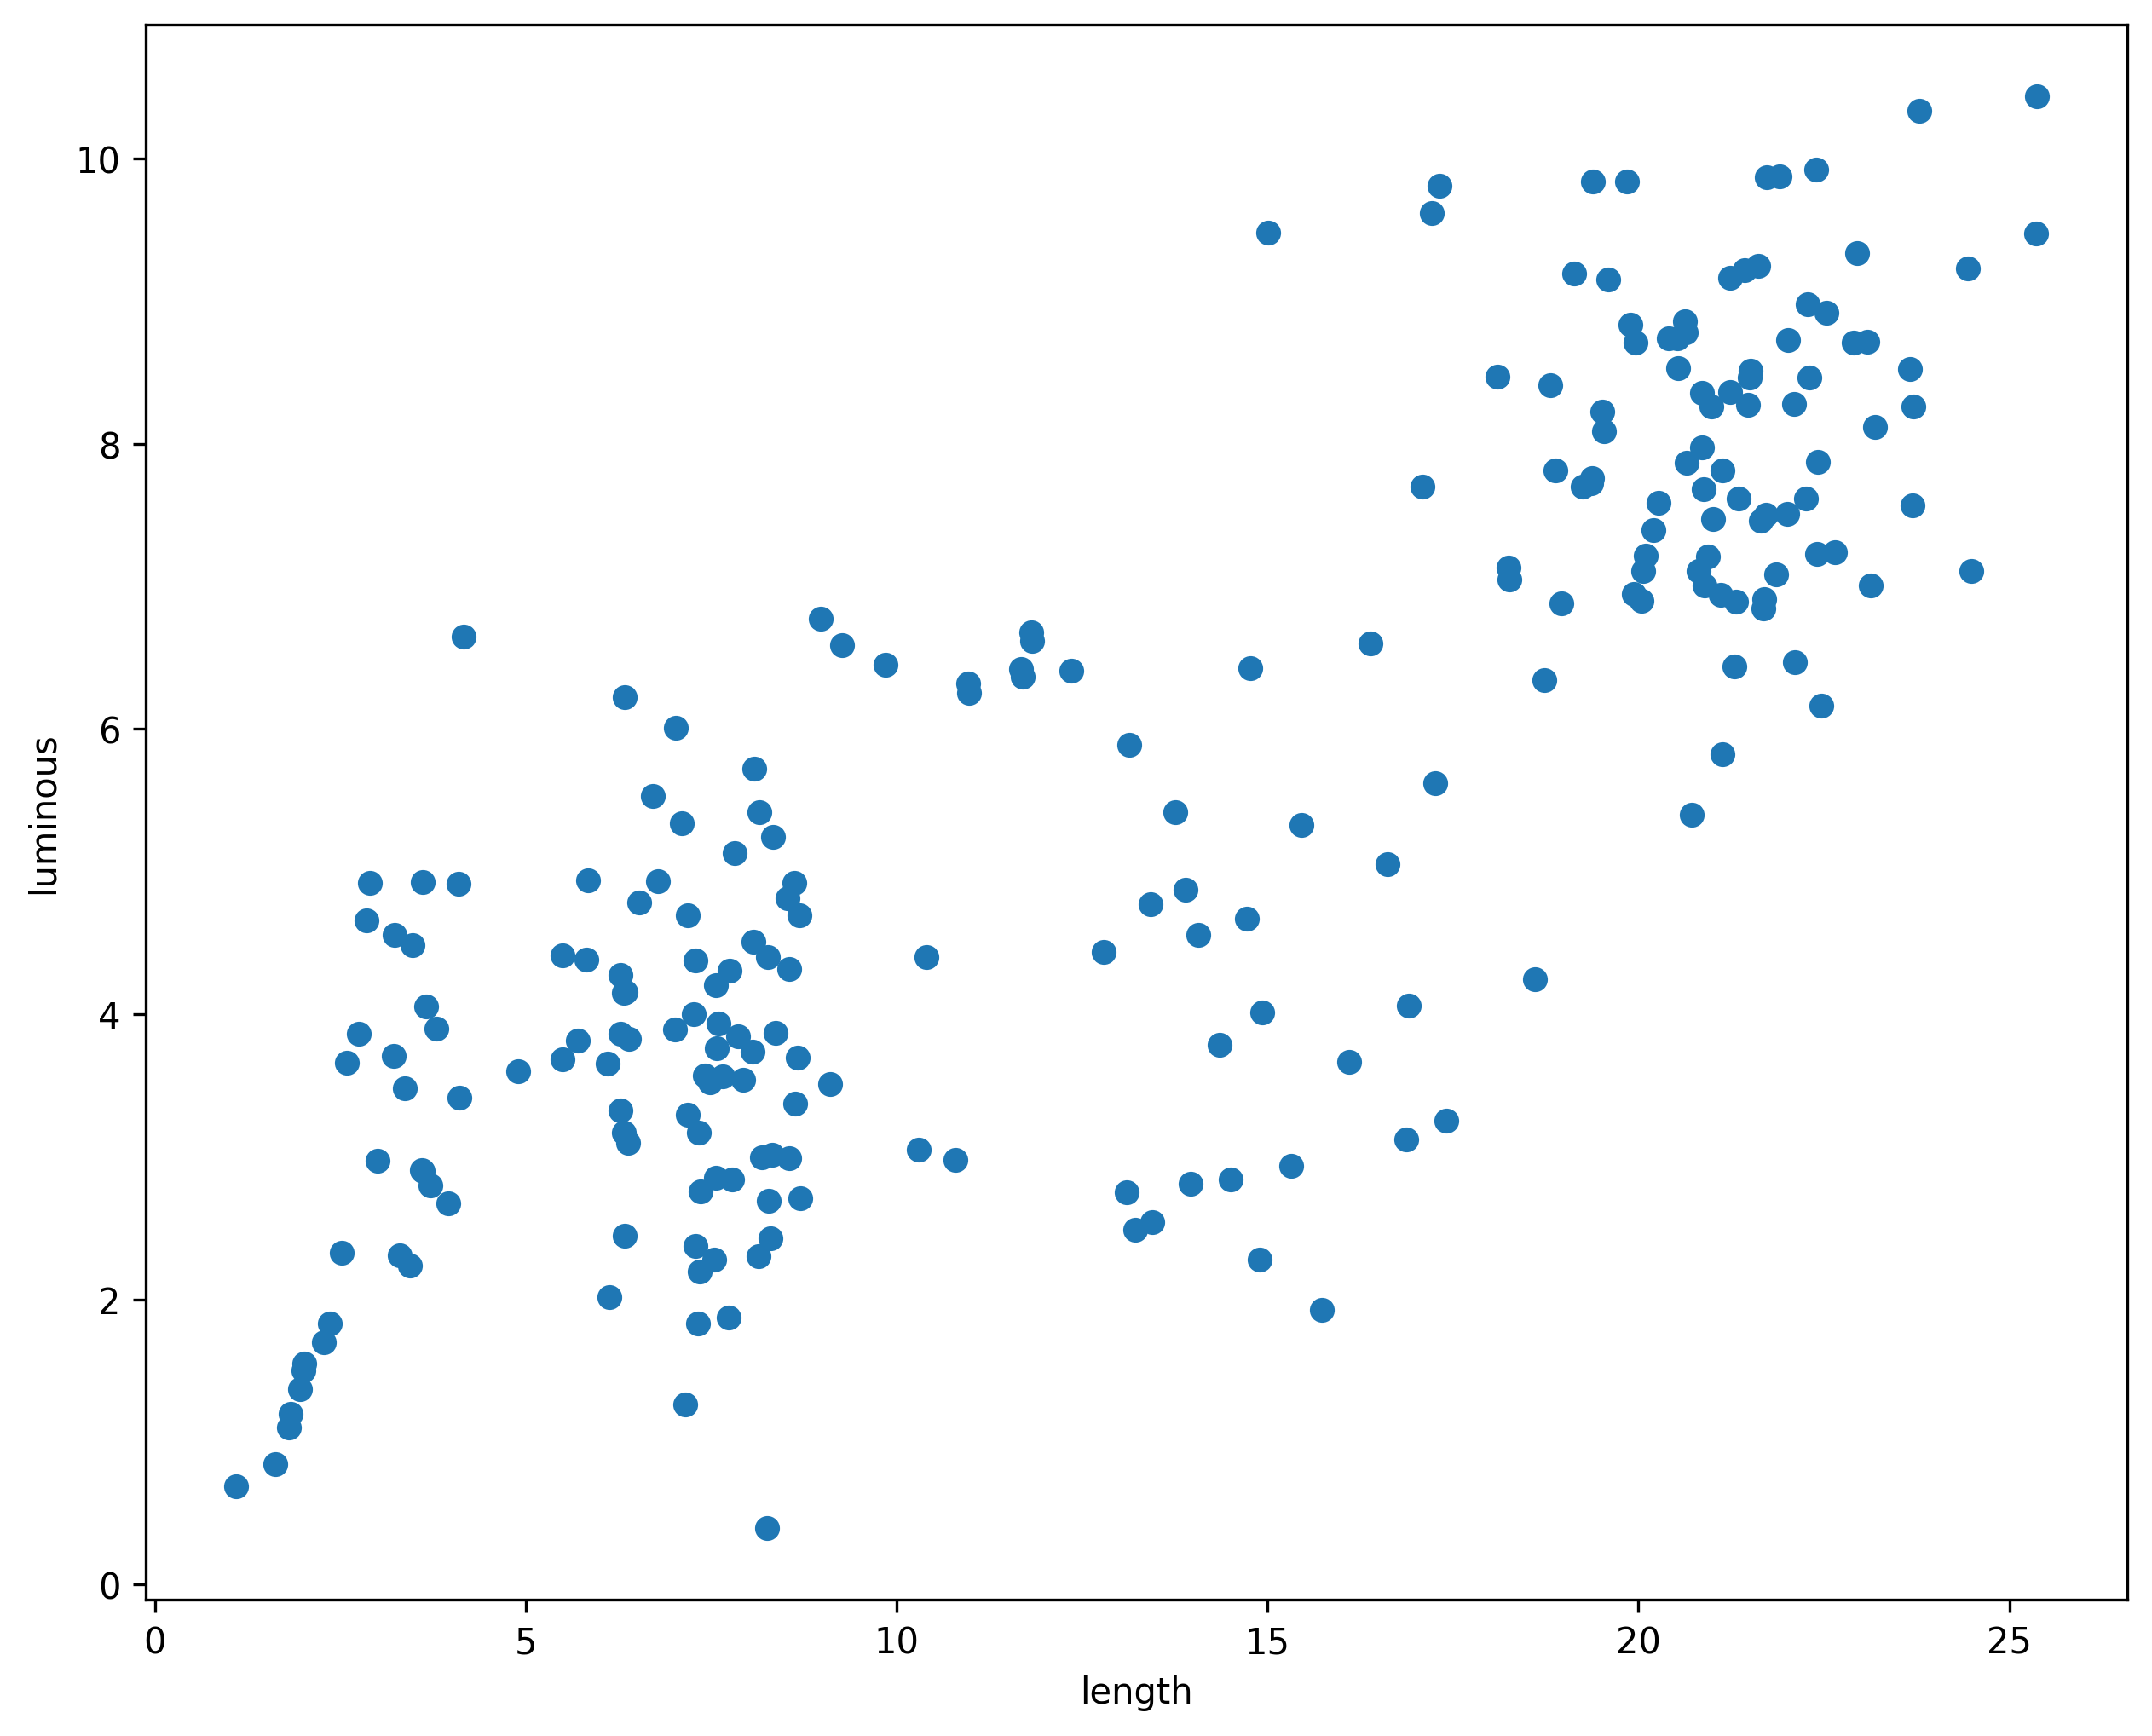

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8),dpi=300)
plt.scatter(fish.length,fish.luminous)
plt.xlabel('length')
plt.ylabel('luminous')
plt.show()

### 2 核回归光滑模型
带宽依次为：
- 固定带宽：0.1、0.5、1.0、1.5、2.0、2.5、5.0
- 最小二乘交叉验证：cv_ls
- AIC Hurvich 带宽估计：aic

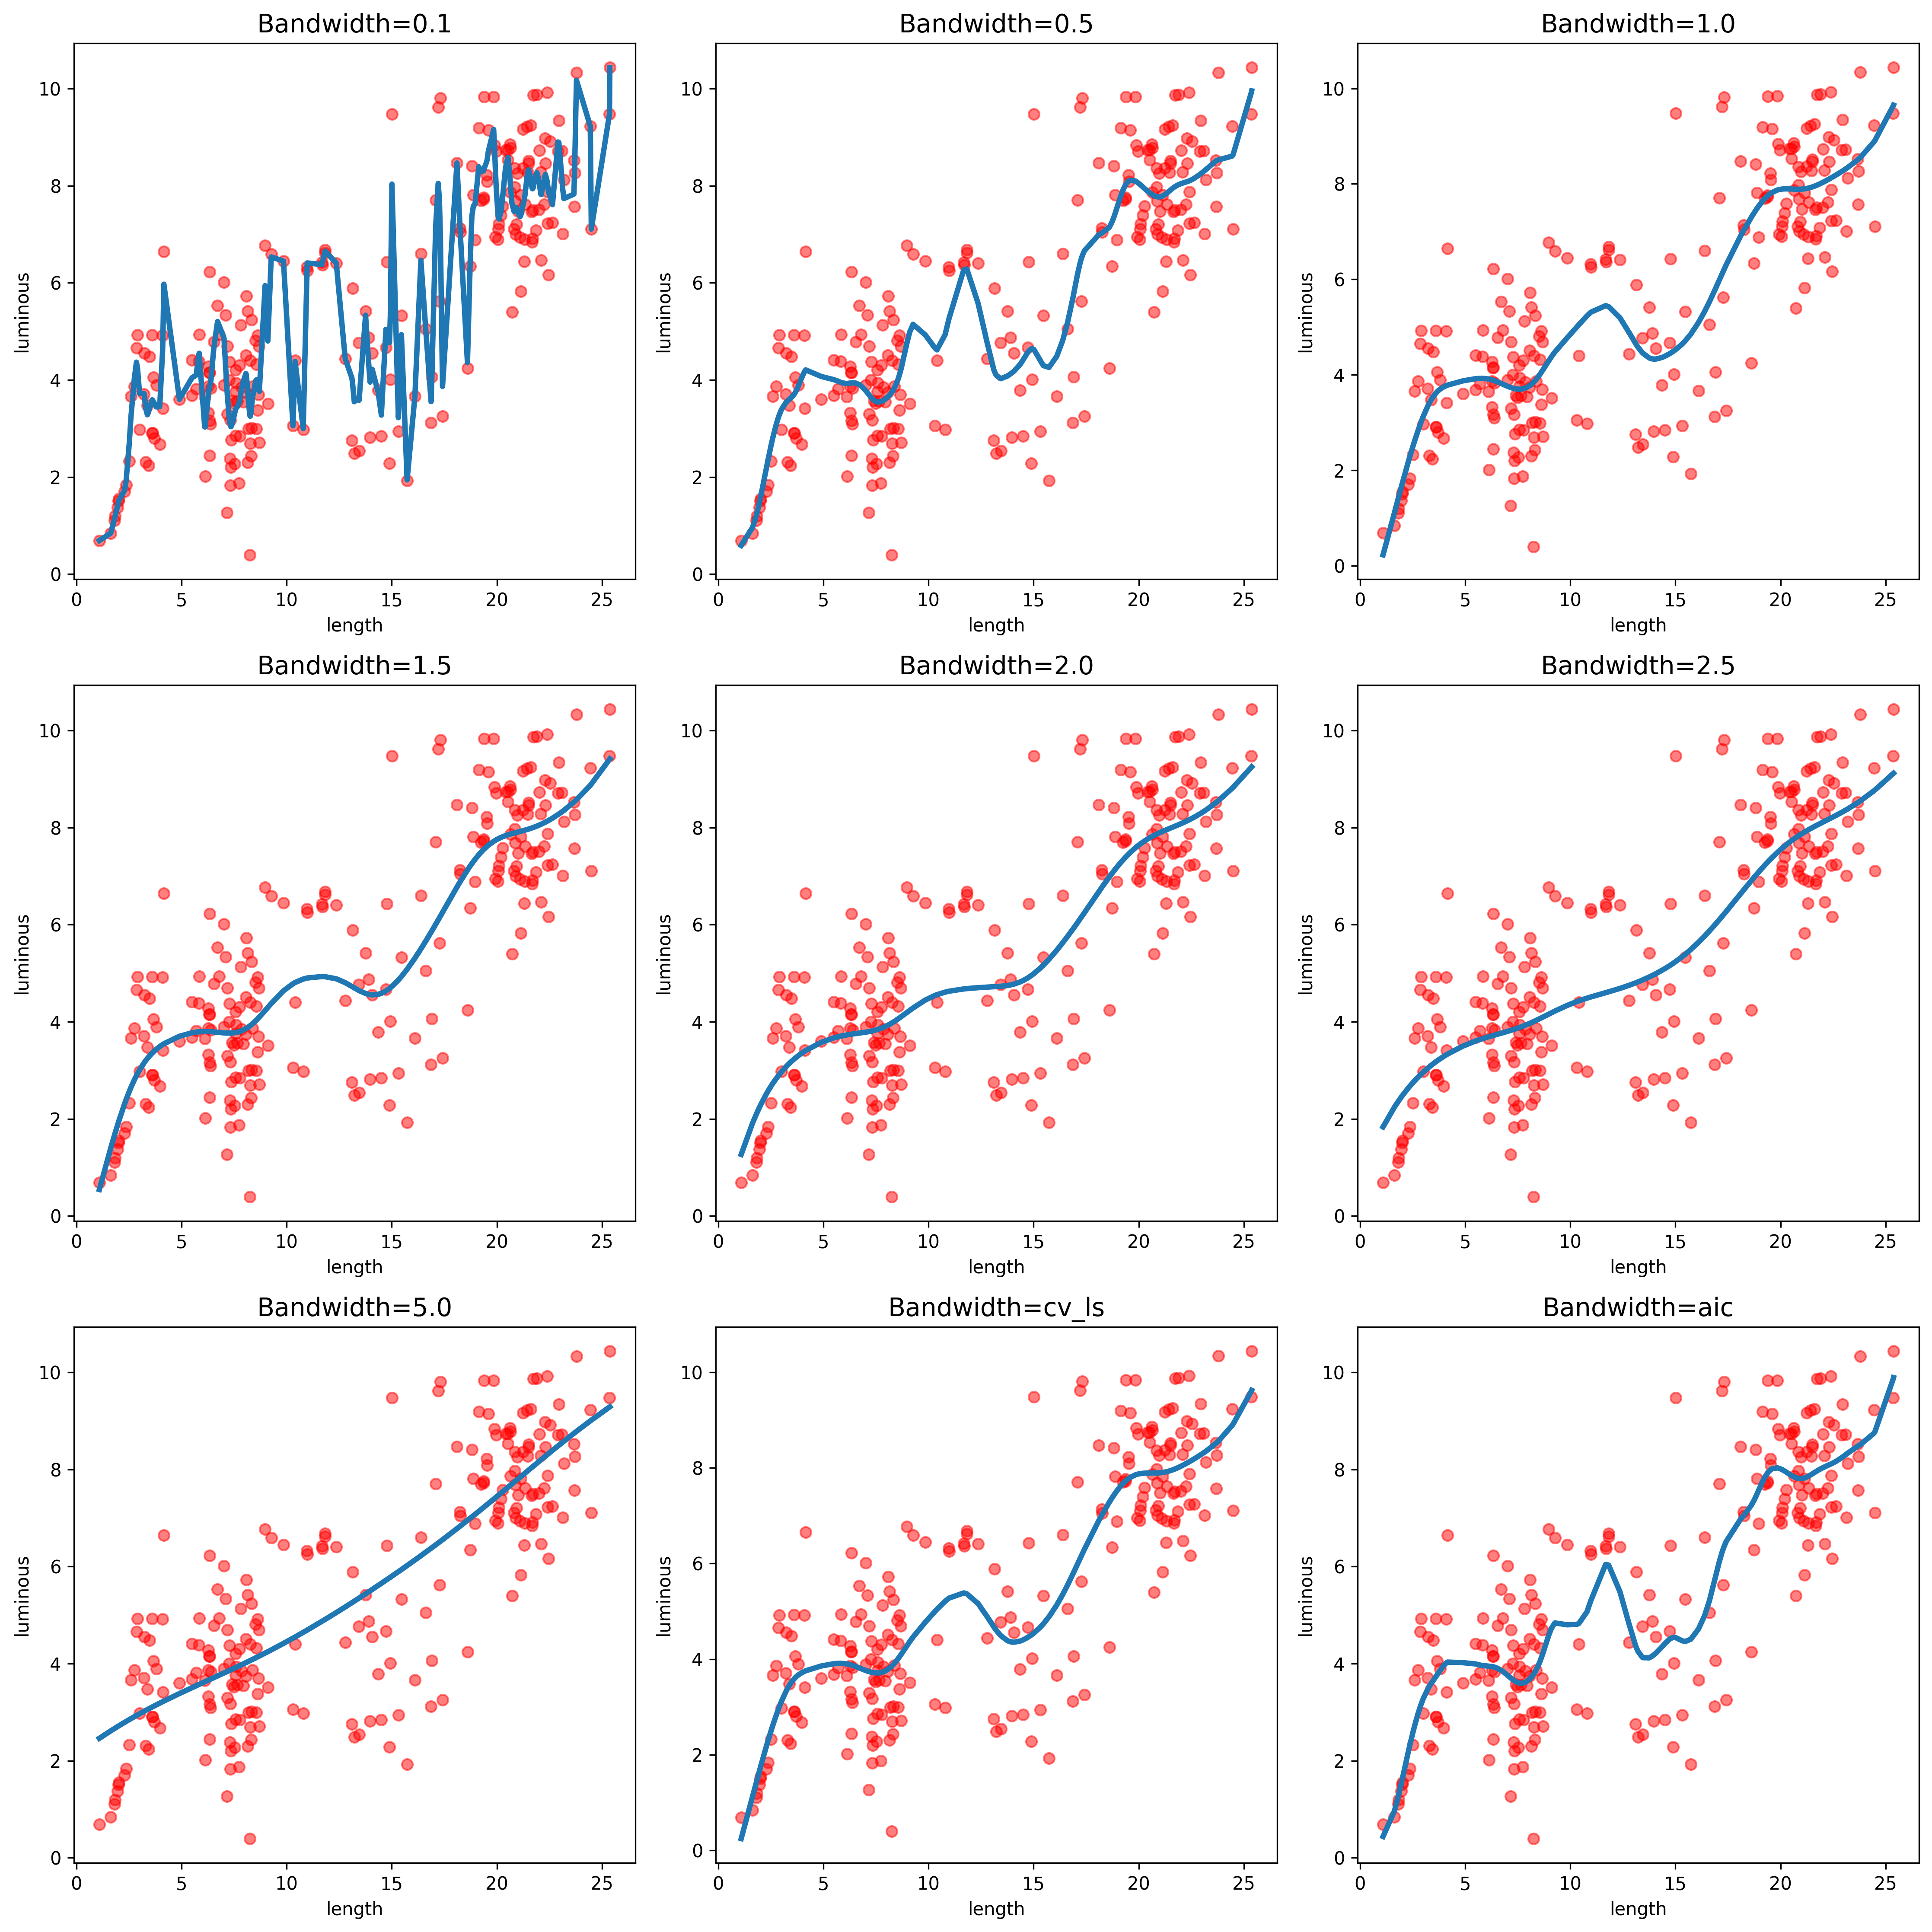

In [4]:
import statsmodels.nonparametric.api as smn

bw = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 5.0, 'cv_ls', 'aic']

fig, axes = plt.subplots(3, 3, figsize=(15, 15), dpi=300)

for i, bandwidth in enumerate(bw):
    row = i // 3
    col = i % 3
    result = smn.KernelReg(fish.luminous, fish.length, bw=[bandwidth] if bandwidth not in ['cv_ls', 'aic'] else bandwidth, var_type='c').fit()
    data1 = pd.DataFrame(np.c_[fish.length, result[0]])
    data1 = data1.sort_values(by=0)
    axes[row, col].set_xlabel('length')
    axes[row, col].set_ylabel('luminous')
    axes[row, col].scatter(fish.length, fish.luminous, c='r', alpha=0.5)
    axes[row, col].set_title(f'Bandwidth={bandwidth}', size=14)
    axes[row, col].plot(data1[0], data1[1], lw=3)

plt.tight_layout()
plt.show()

### 3 局部多项式回归
- 1维多项式近似
- 2维多项式近似
- 对比核为“cv_ls”的核回归光滑

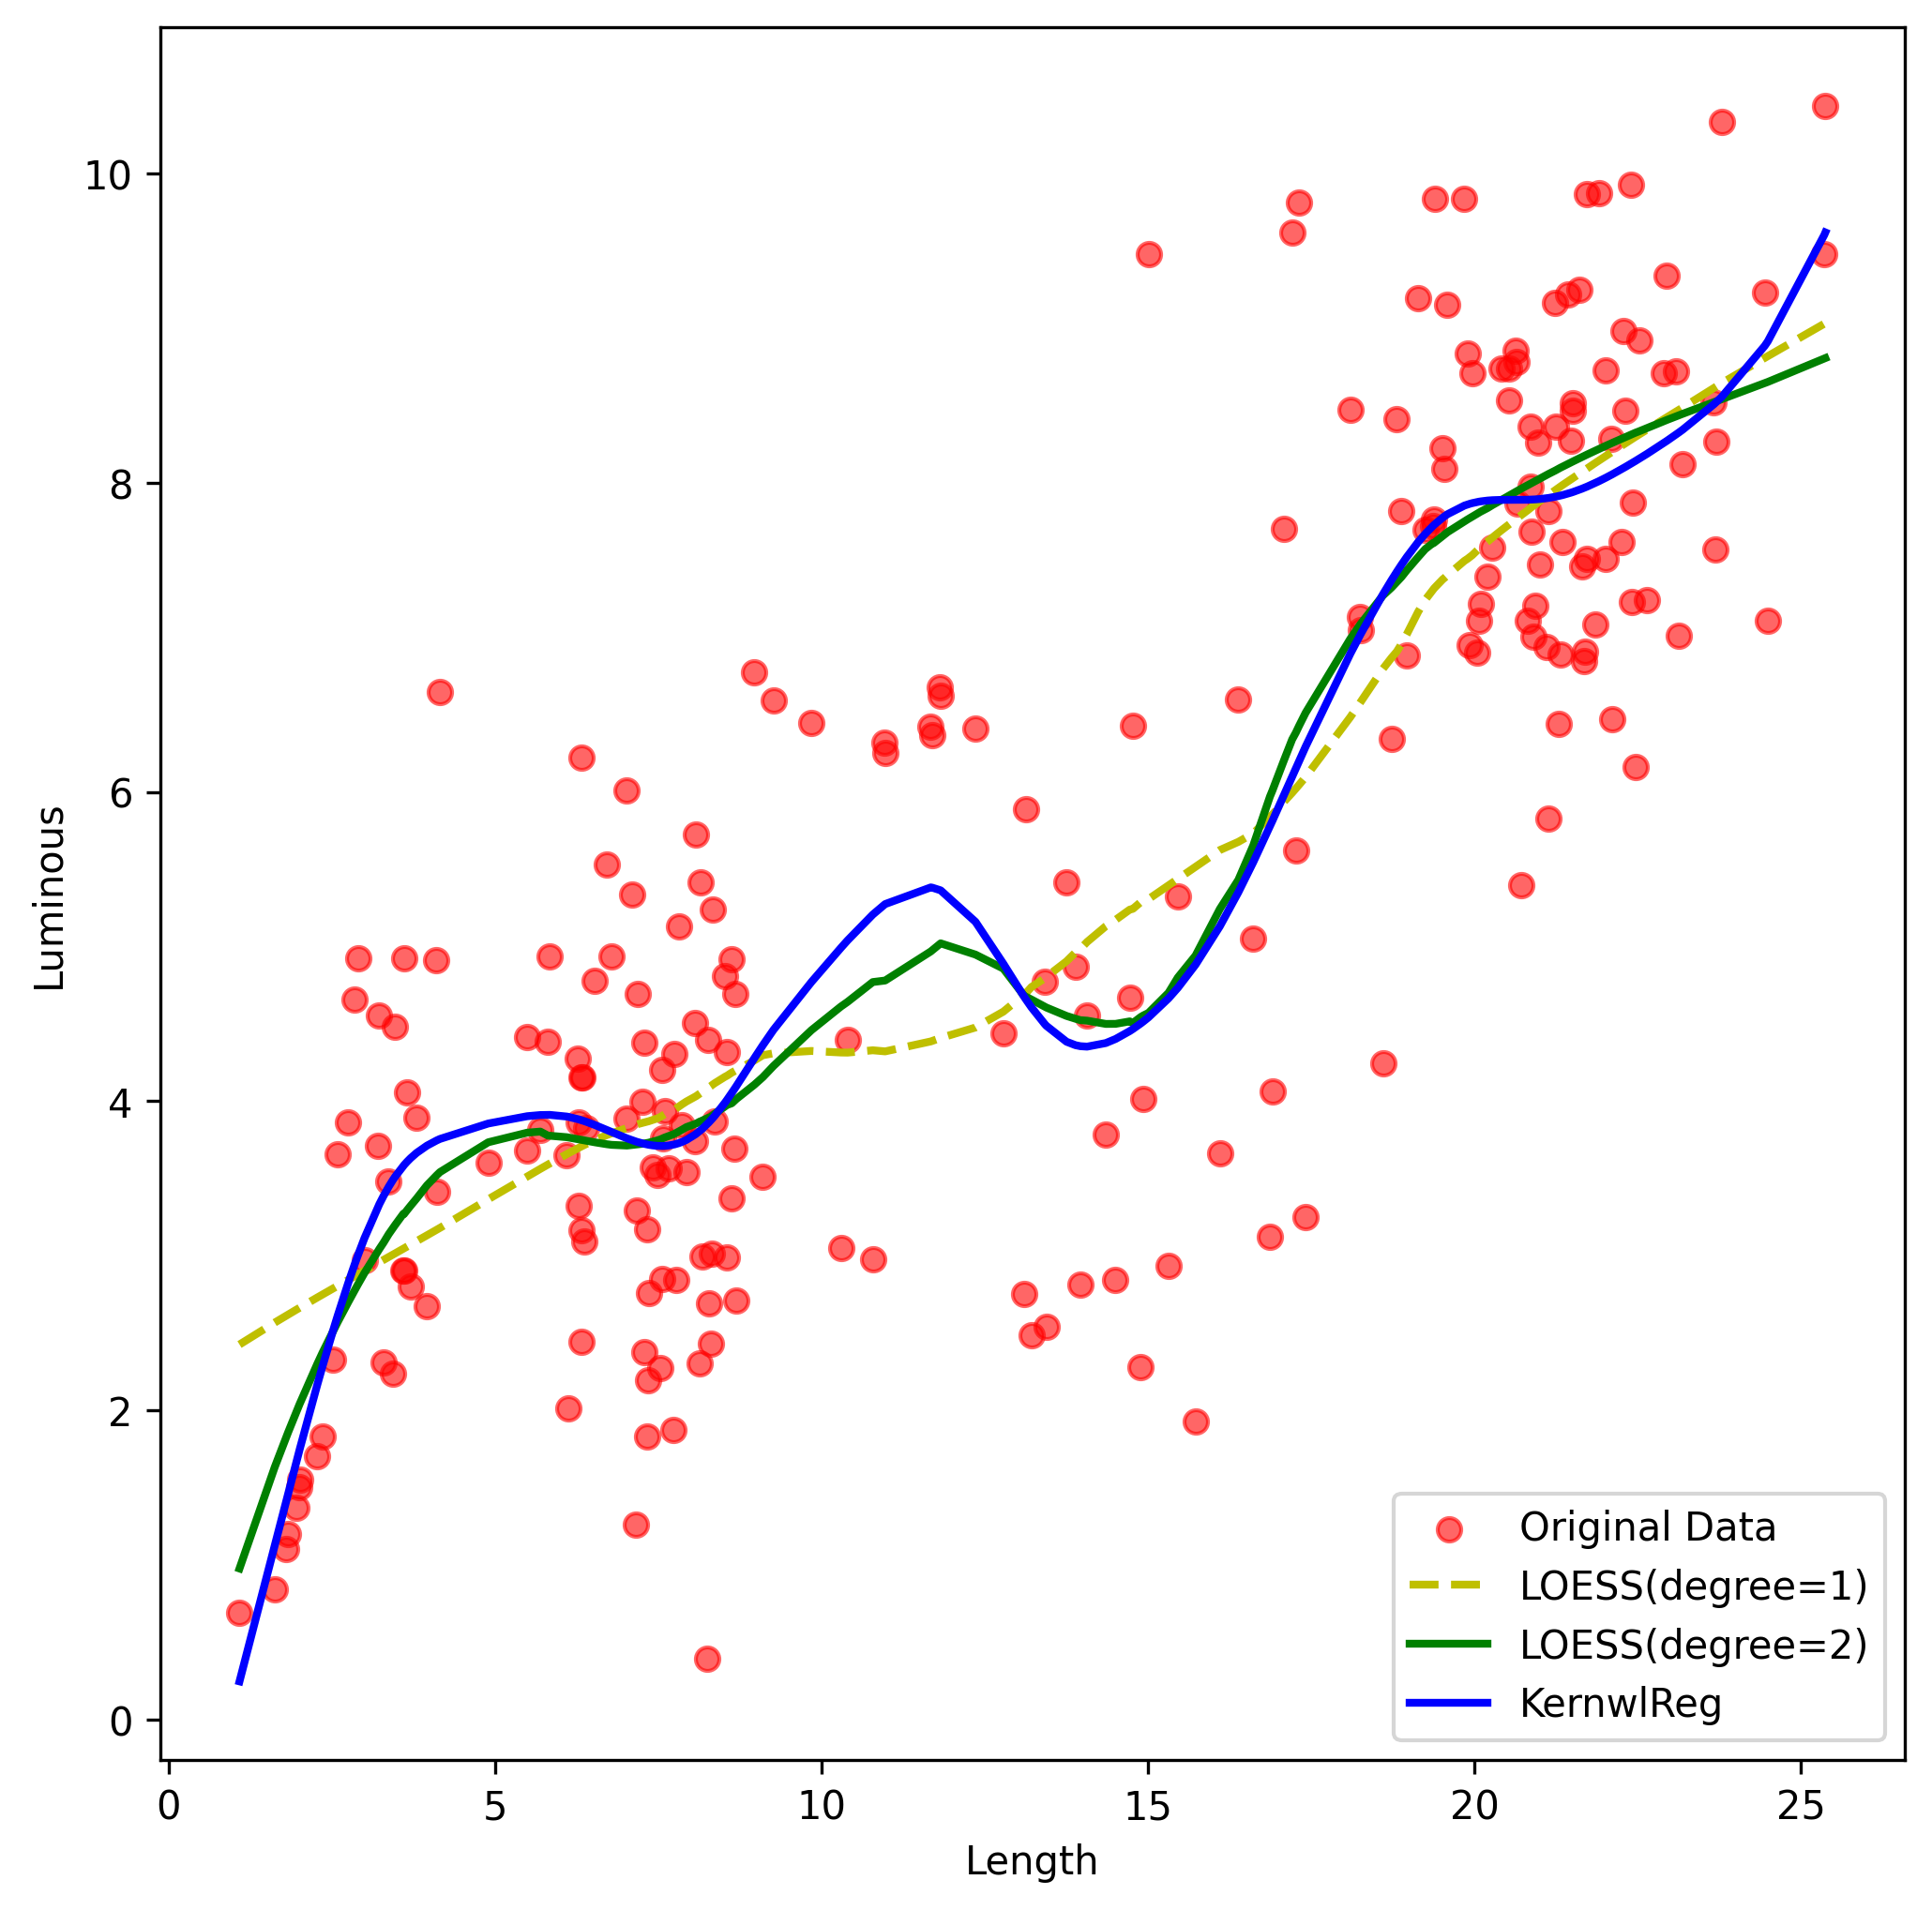

In [5]:
import loess
from loess.loess_1d import loess_1d


plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')

# 局部多项式回归
xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=1)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'y--', linewidth=2, label='LOESS(degree=1)')

xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g', linewidth=2, label='LOESS(degree=2)')

# 核回归光滑
result = smn.KernelReg(fish.luminous, fish.length, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[fish.length, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], color='b', linewidth=2, label='KernwlReg')

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower right')
plt.show()

### 4 Lowess稳健回归
- 为了展现稳健回归的Robust，给原始数据增加异常值，可以看出Lowess受异常值影响最小
- 对比核回归光滑
- 对比局部多项式回归

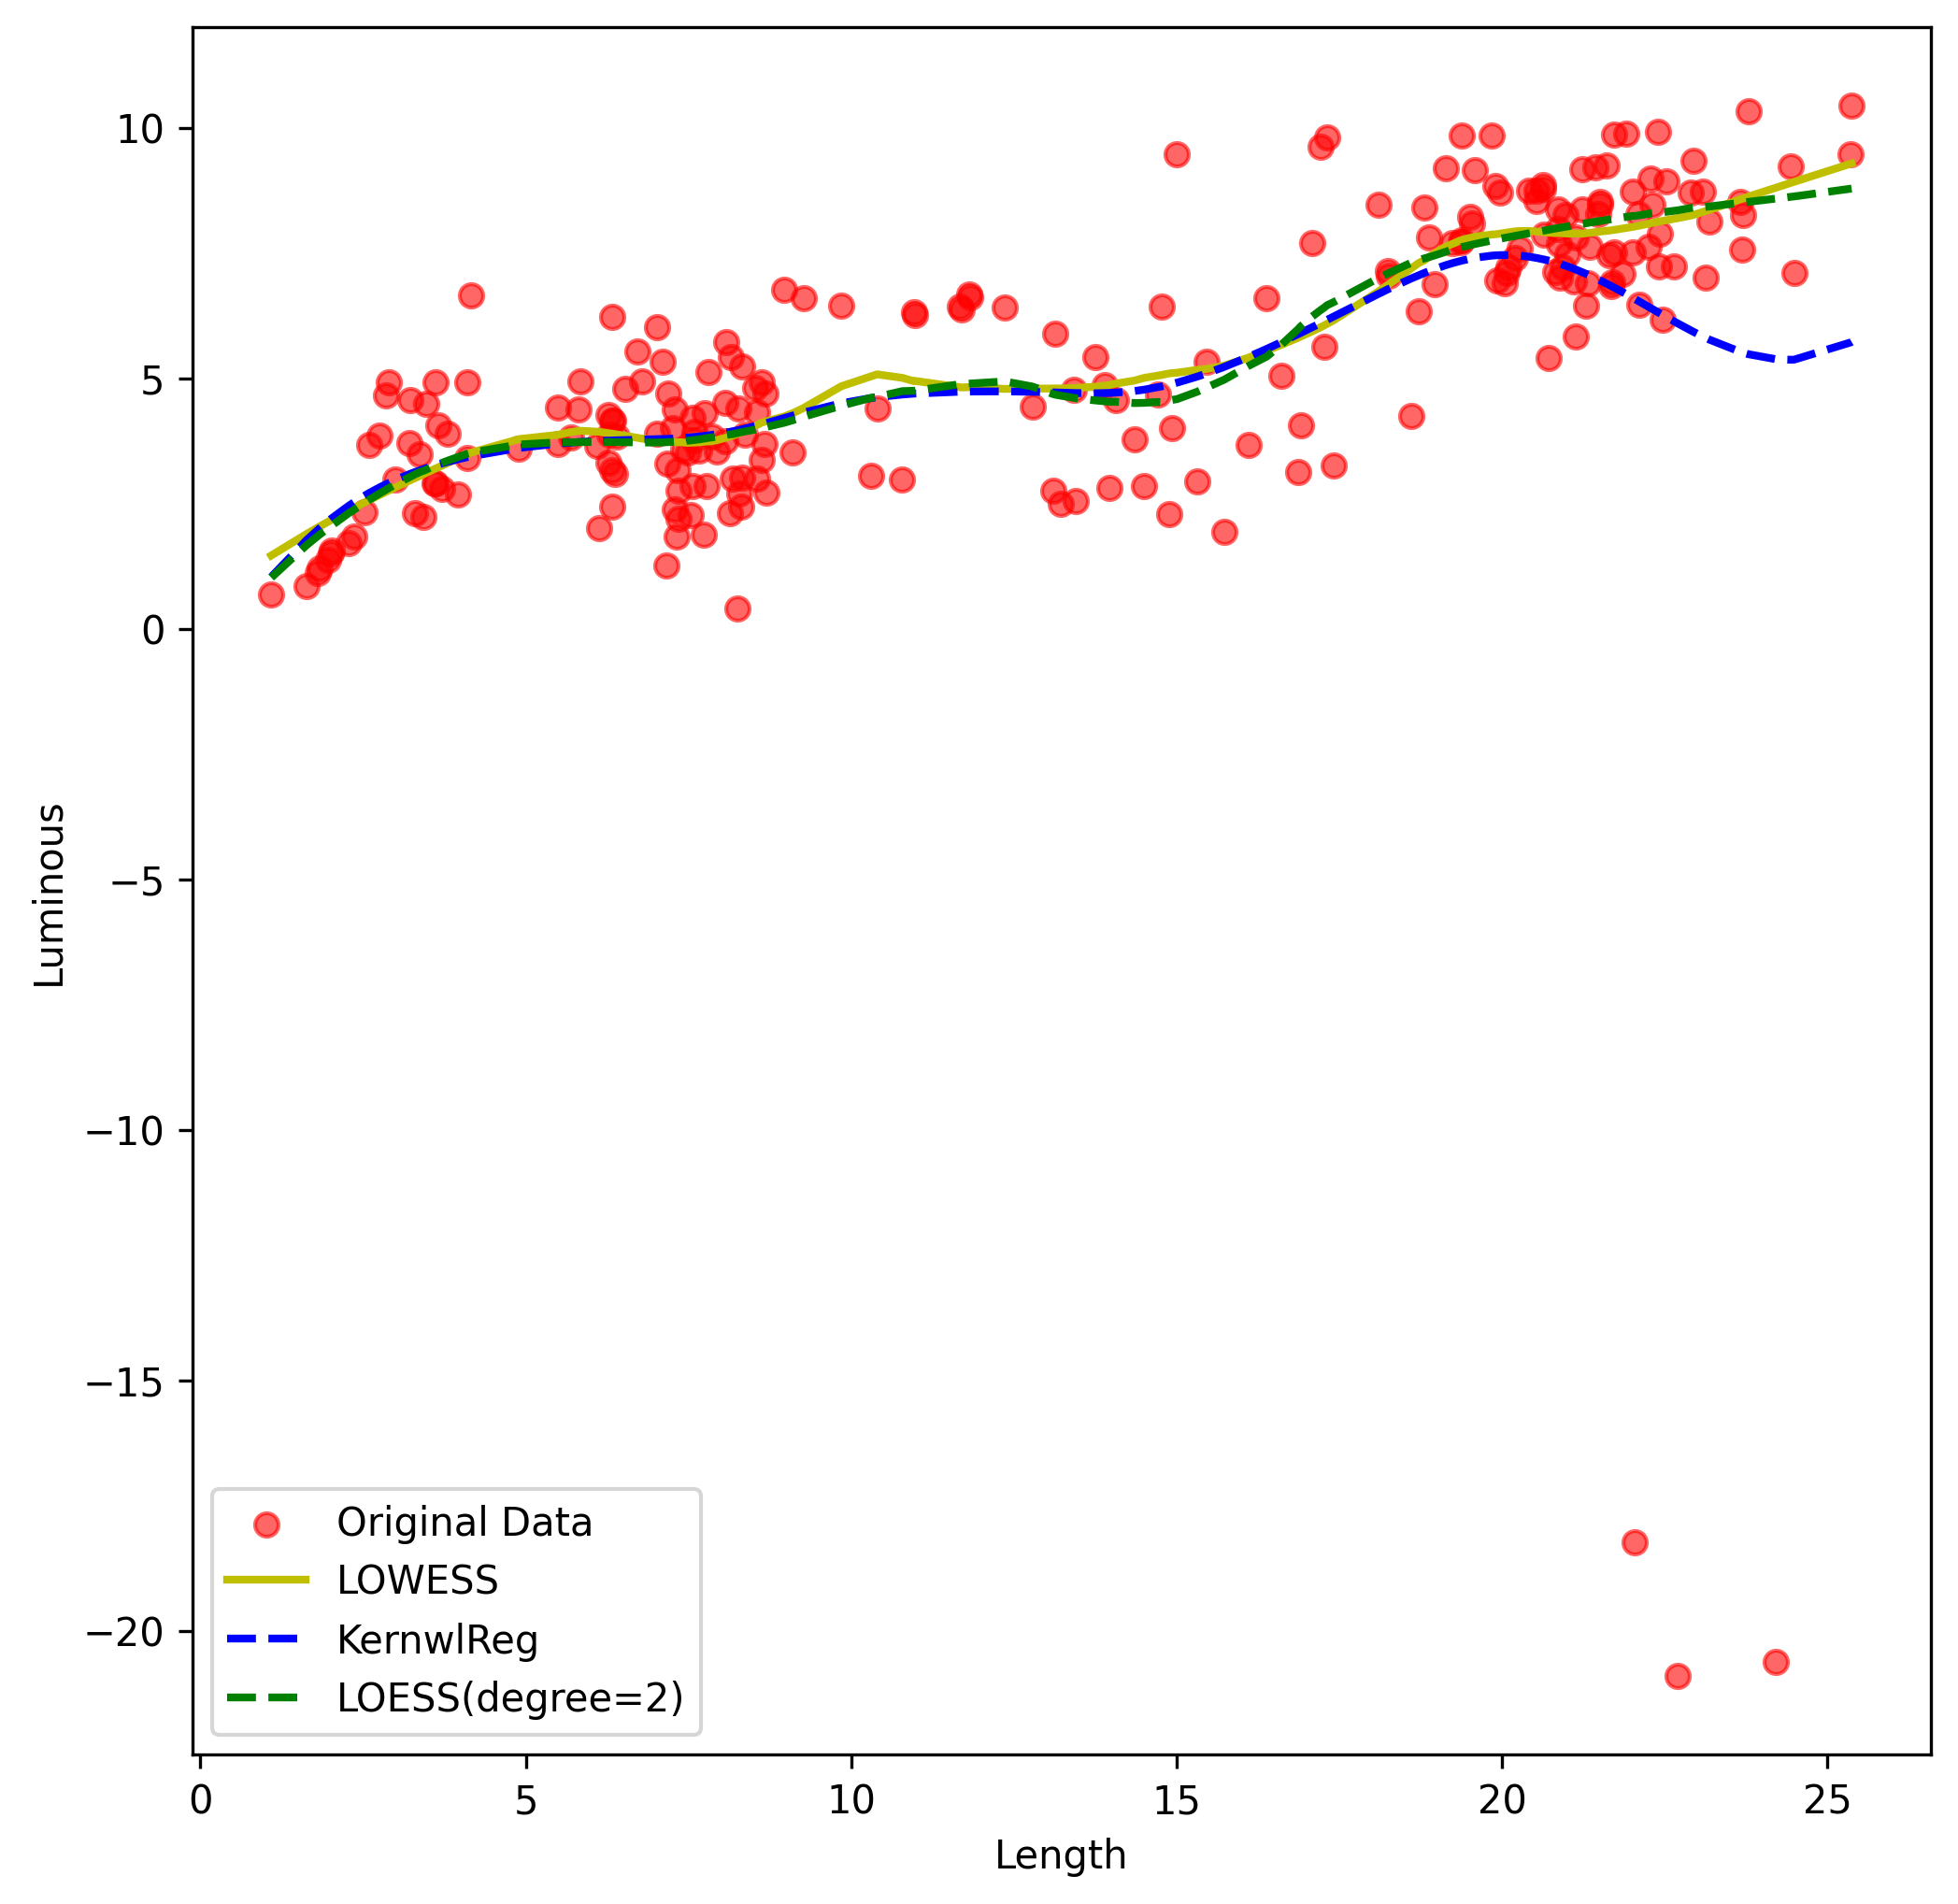

In [6]:
x = np.concatenate([np.array(fish.length),np.array([22.03784,24.21510,22.70523])],axis=0)
y = np.concatenate([np.array(fish.luminous),np.array([-18.22867,-20.62153,-20.90481])],axis=0)

plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(x, y, alpha=0.6, label='Original Data', color='r')

# LOWESS稳健回归
lowess_fish=smn.lowess(y, x, frac=0.3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1], 'y', linewidth=2, label='LOWESS')

# 核回归光滑模型
result = smn.KernelReg(y, x, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[x, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], 'b--', linewidth=2, label='KernwlReg')

# 局部多项式回归
xout, yout, weigts = loess_1d(x, y, frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g--', linewidth=2, label='LOESS(degree=2)')

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower left')
plt.show()

### 5 K近邻回归
#### 5.1 对比不同K值的结果

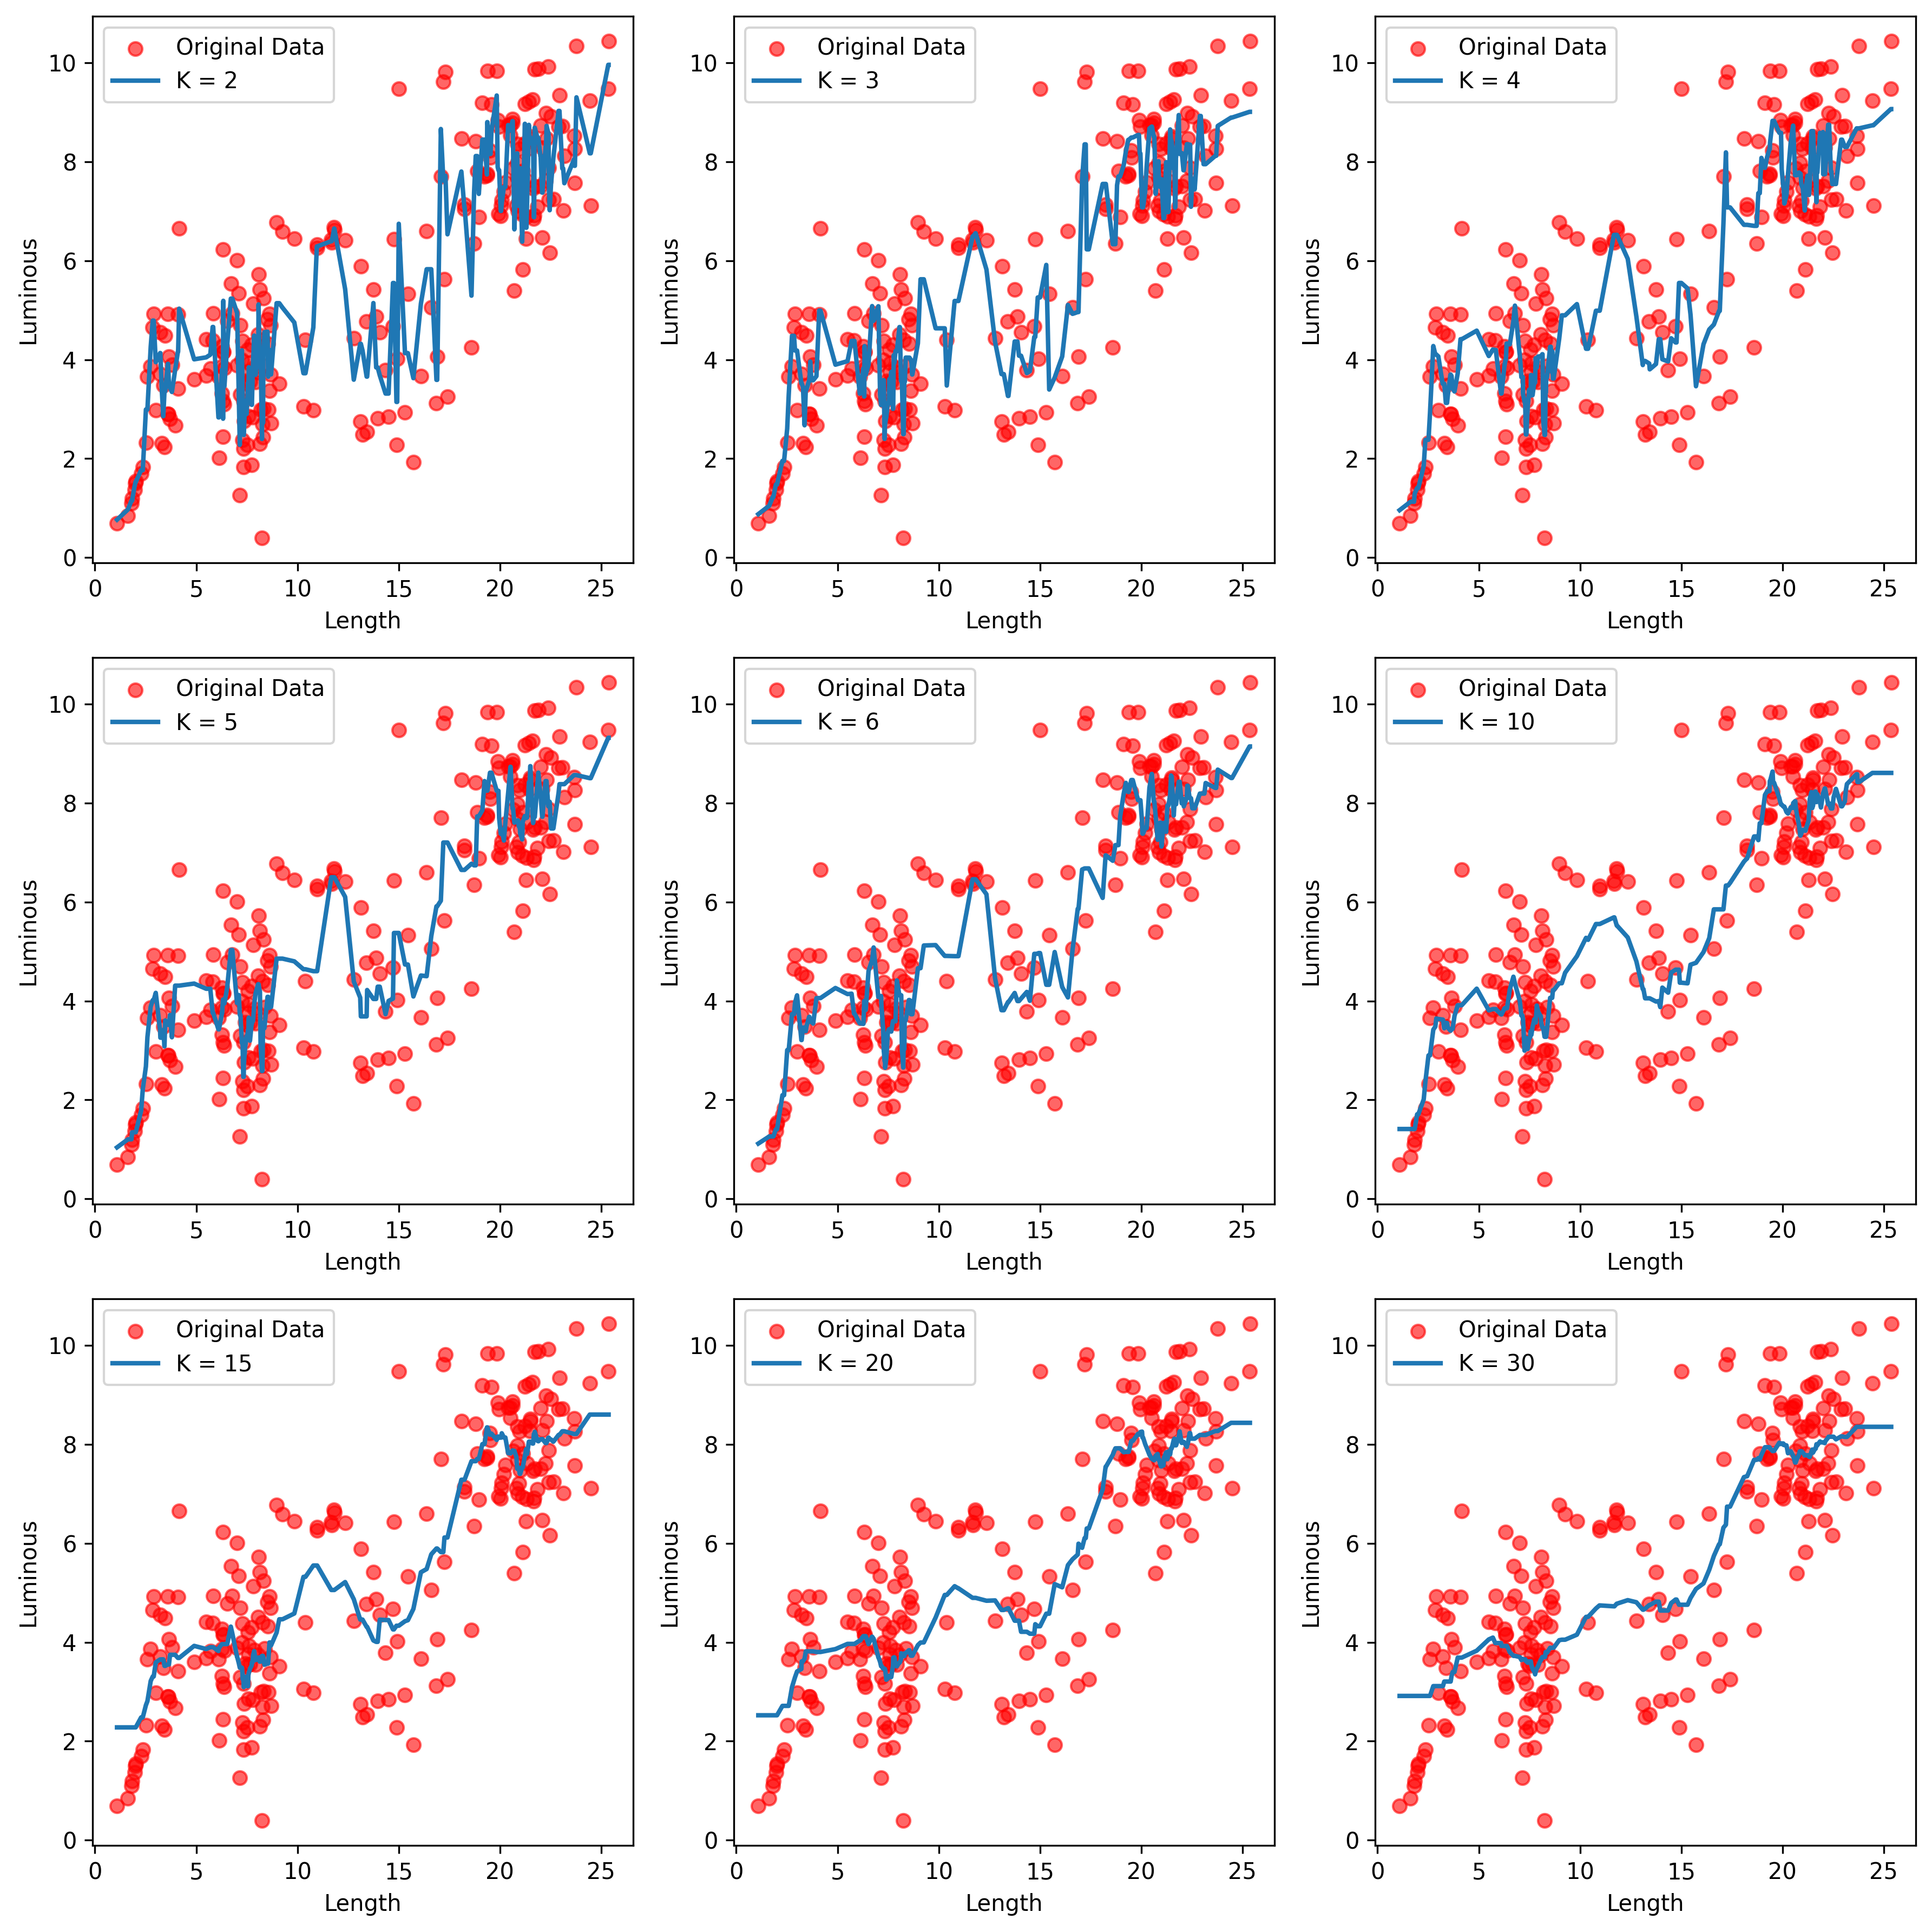

In [7]:
from sklearn.neighbors import KNeighborsRegressor

# k值
neighbors = [2, 3, 4, 5, 6, 10, 15, 20, 30]

fig, axes = plt.subplots(3, 3, figsize=(12, 12), dpi=300)
axes = axes.flatten()

for i, neighbor in enumerate(neighbors):
    ax = axes[i]
    ax.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')
    dis_knr = KNeighborsRegressor(weights="uniform", n_neighbors=neighbor)
    result = dis_knr.fit(np.asarray(fish.length).reshape(-1, 1), fish.luminous)
    pre1 = result.predict(np.asarray(fish.length).reshape(-1, 1))
    data = pd.DataFrame(np.c_[fish.length, pre1]).sort_values(by=0)
    ax.plot(data[0], data[1], lw=2, label='K = ' + str(neighbor))
    ax.set_xlabel('Length')
    ax.set_ylabel('Luminous')
    ax.legend()

plt.tight_layout()
plt.show()

#### 5.2 K近邻回归与其他回归对比

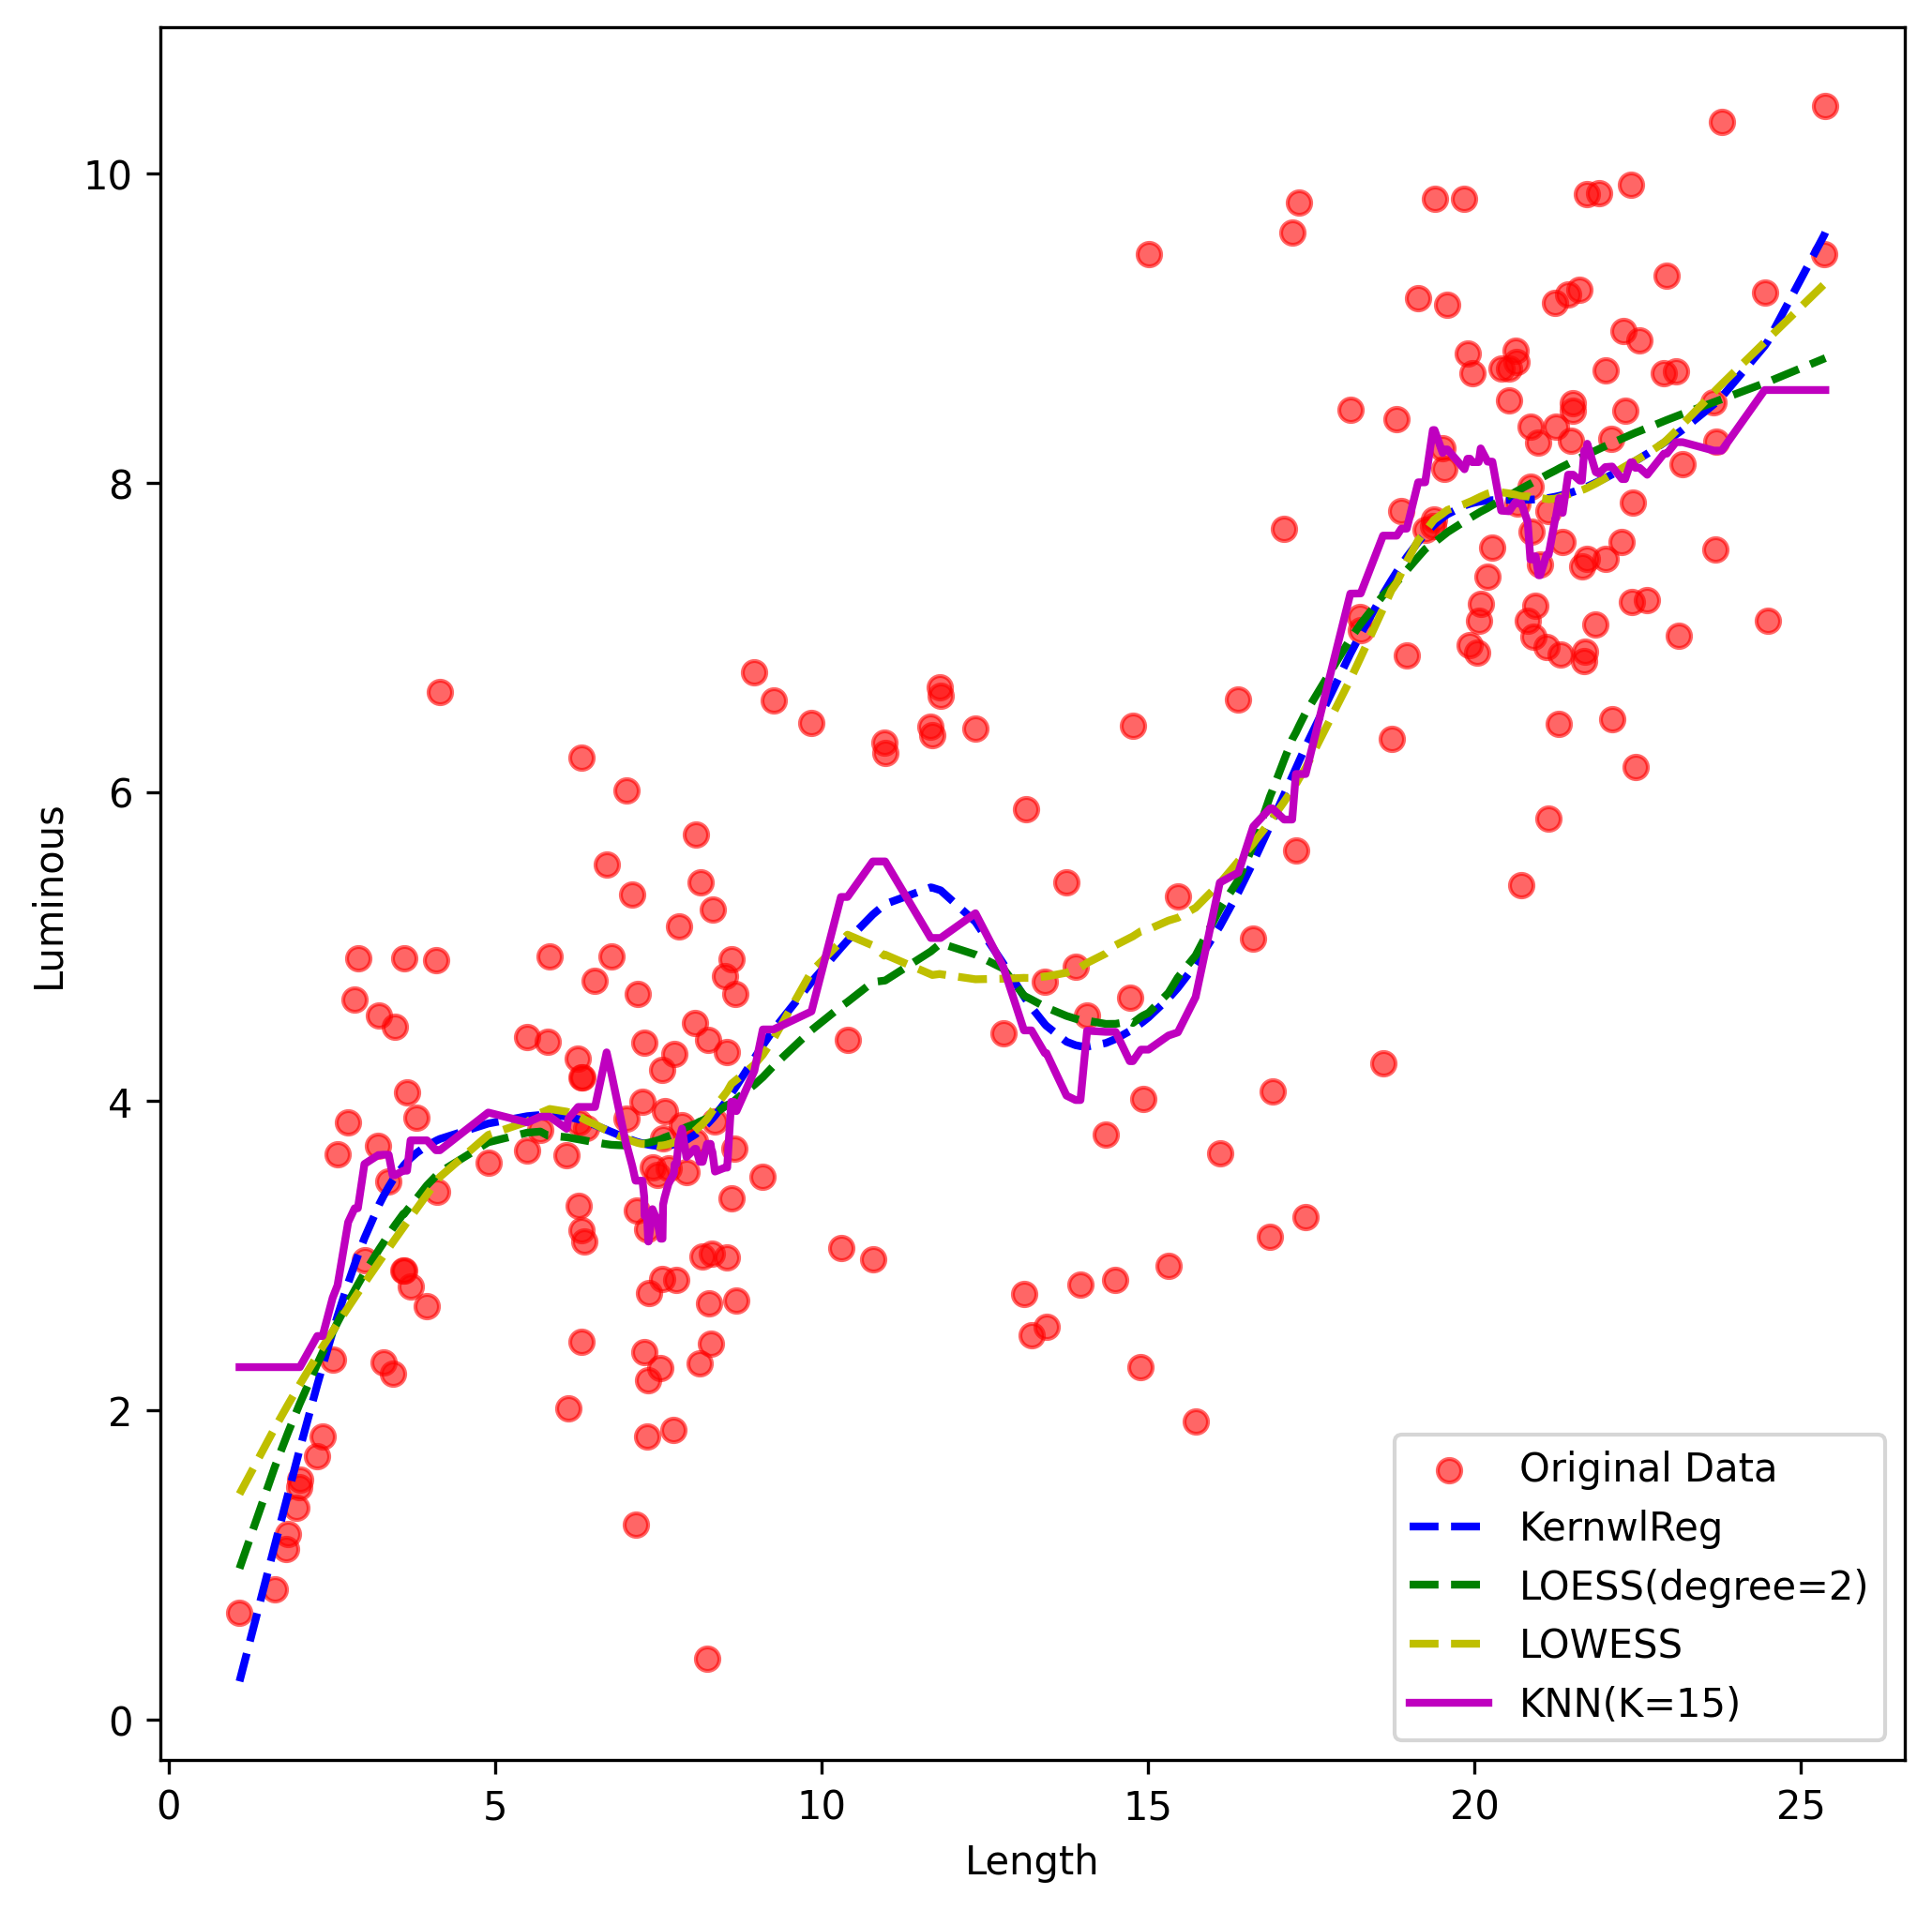

In [8]:
plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')

# 核回归光滑
result = smn.KernelReg(fish.luminous, fish.length, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[fish.length, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], 'b--', linewidth=2, label='KernwlReg')

# 局部多项式回归
xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g--', linewidth=2, label='LOESS(degree=2)')

# LOWESS稳健回归
lowess_fish=smn.lowess(fish.luminous, fish.length, frac=0.3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1], 'y--', linewidth=2, label='LOWESS')

# K为15的K近邻回归
knr = KNeighborsRegressor(n_neighbors=15)
knr.fit(np.array(fish.length).reshape(-1, 1), fish.luminous)
pre = knr.predict(np.array(fish.length).reshape(-1, 1))
knr_data = pd.DataFrame(np.c_[fish.length, pre]).sort_values(by=0)
plt.plot(knr_data[0], knr_data[1], 'm', linewidth=2, label='KNN(K=15)')

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower right')
plt.show()

### 6 正交序列回归：Legendre多项式
#### 6.1 不同阶数对比

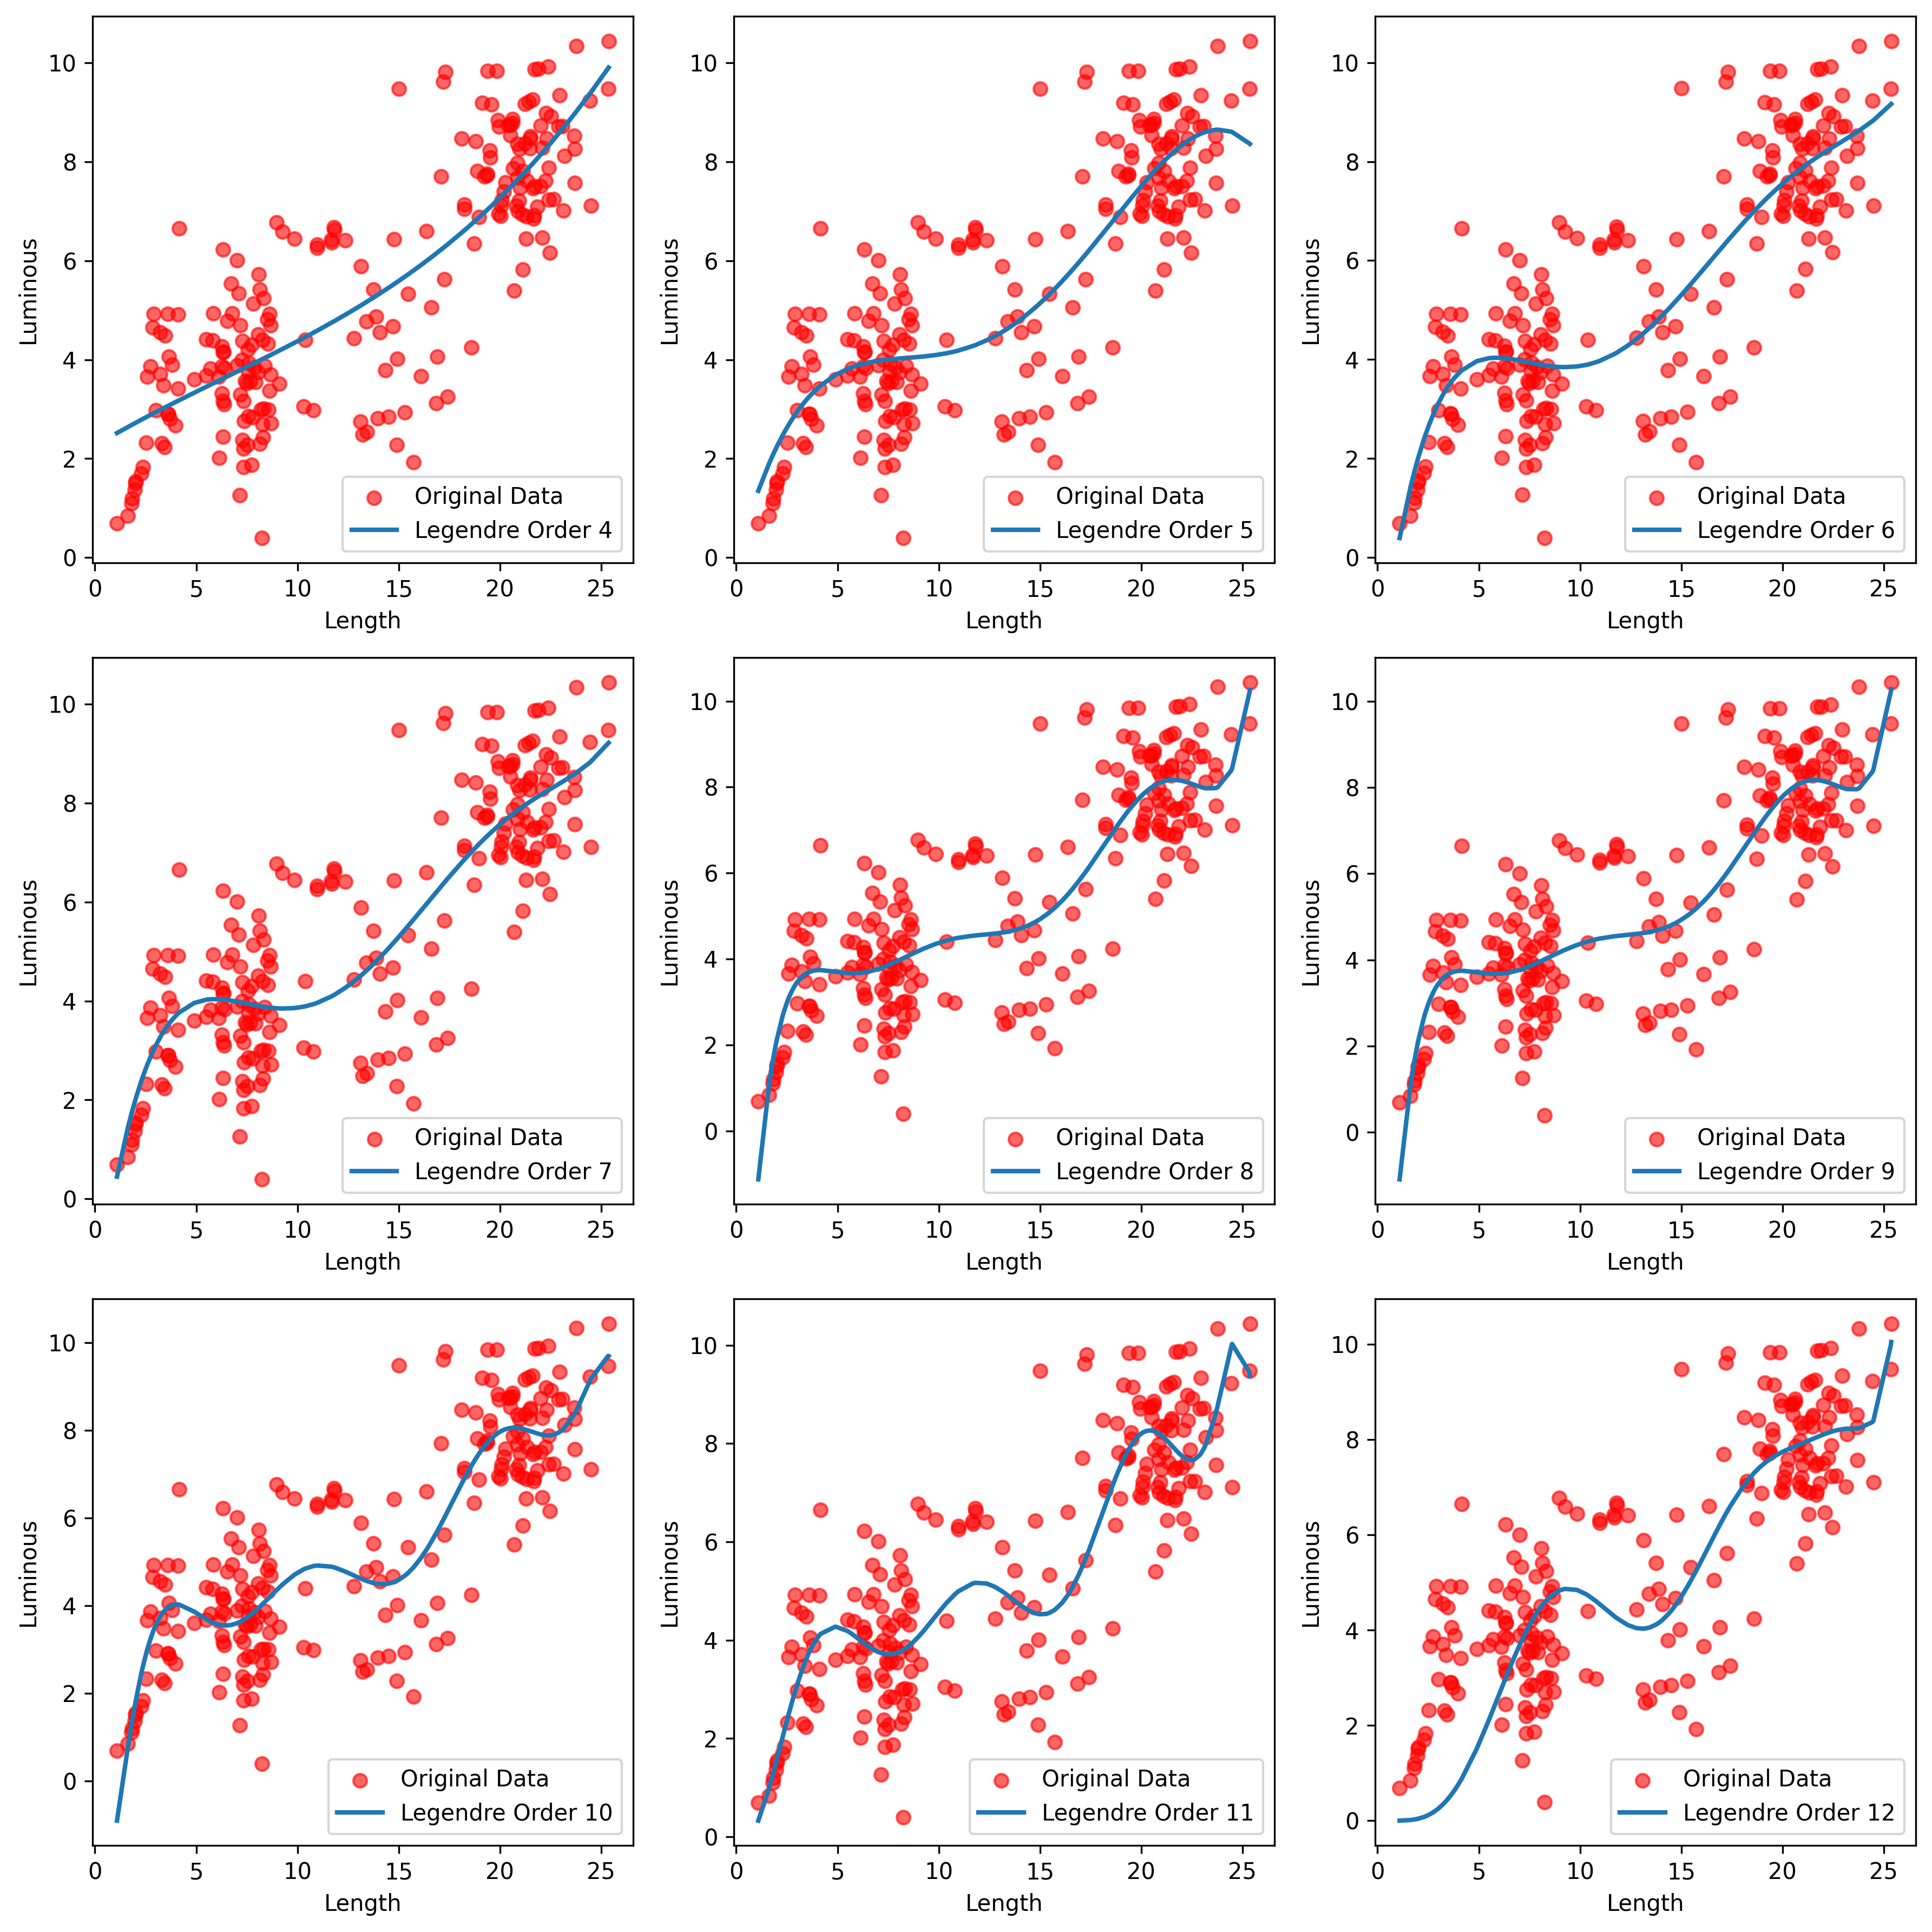

In [9]:
from numpy.polynomial import legendre
import statsmodels.formula.api as smf

fig, axes = plt.subplots(3, 3, figsize=(12, 12), dpi=300)
axes = axes.flatten()

x = fish.length
y = fish.luminous
data = {'x': x, 'y': y}

def legendre_poly(x, order):
    return legendre.legvander(x, order - 1)[:, 1:]

orders = range(4, 13)

for i, order in enumerate(orders):
    formula = f'y~1+legendre_poly(x, {order})'
    orthpoly_model = smf.ols(formula=formula, data=data)
    result = orthpoly_model.fit()
    y_hat = result.predict()
    plot_data = pd.DataFrame(np.c_[x, y_hat]).sort_values(by=0)

    axes[i].scatter(x, y, alpha=0.6, label='Original Data', color='r')
    axes[i].plot(plot_data[0], plot_data[1], linewidth=2, label=f'Legendre Order {order}')
    axes[i].set_xlabel('Length')
    axes[i].set_ylabel('Luminous')
    axes[i].legend(loc='lower right')

plt.tight_layout()
plt.show()

#### 6.2 正交序列回归与其他模型对比

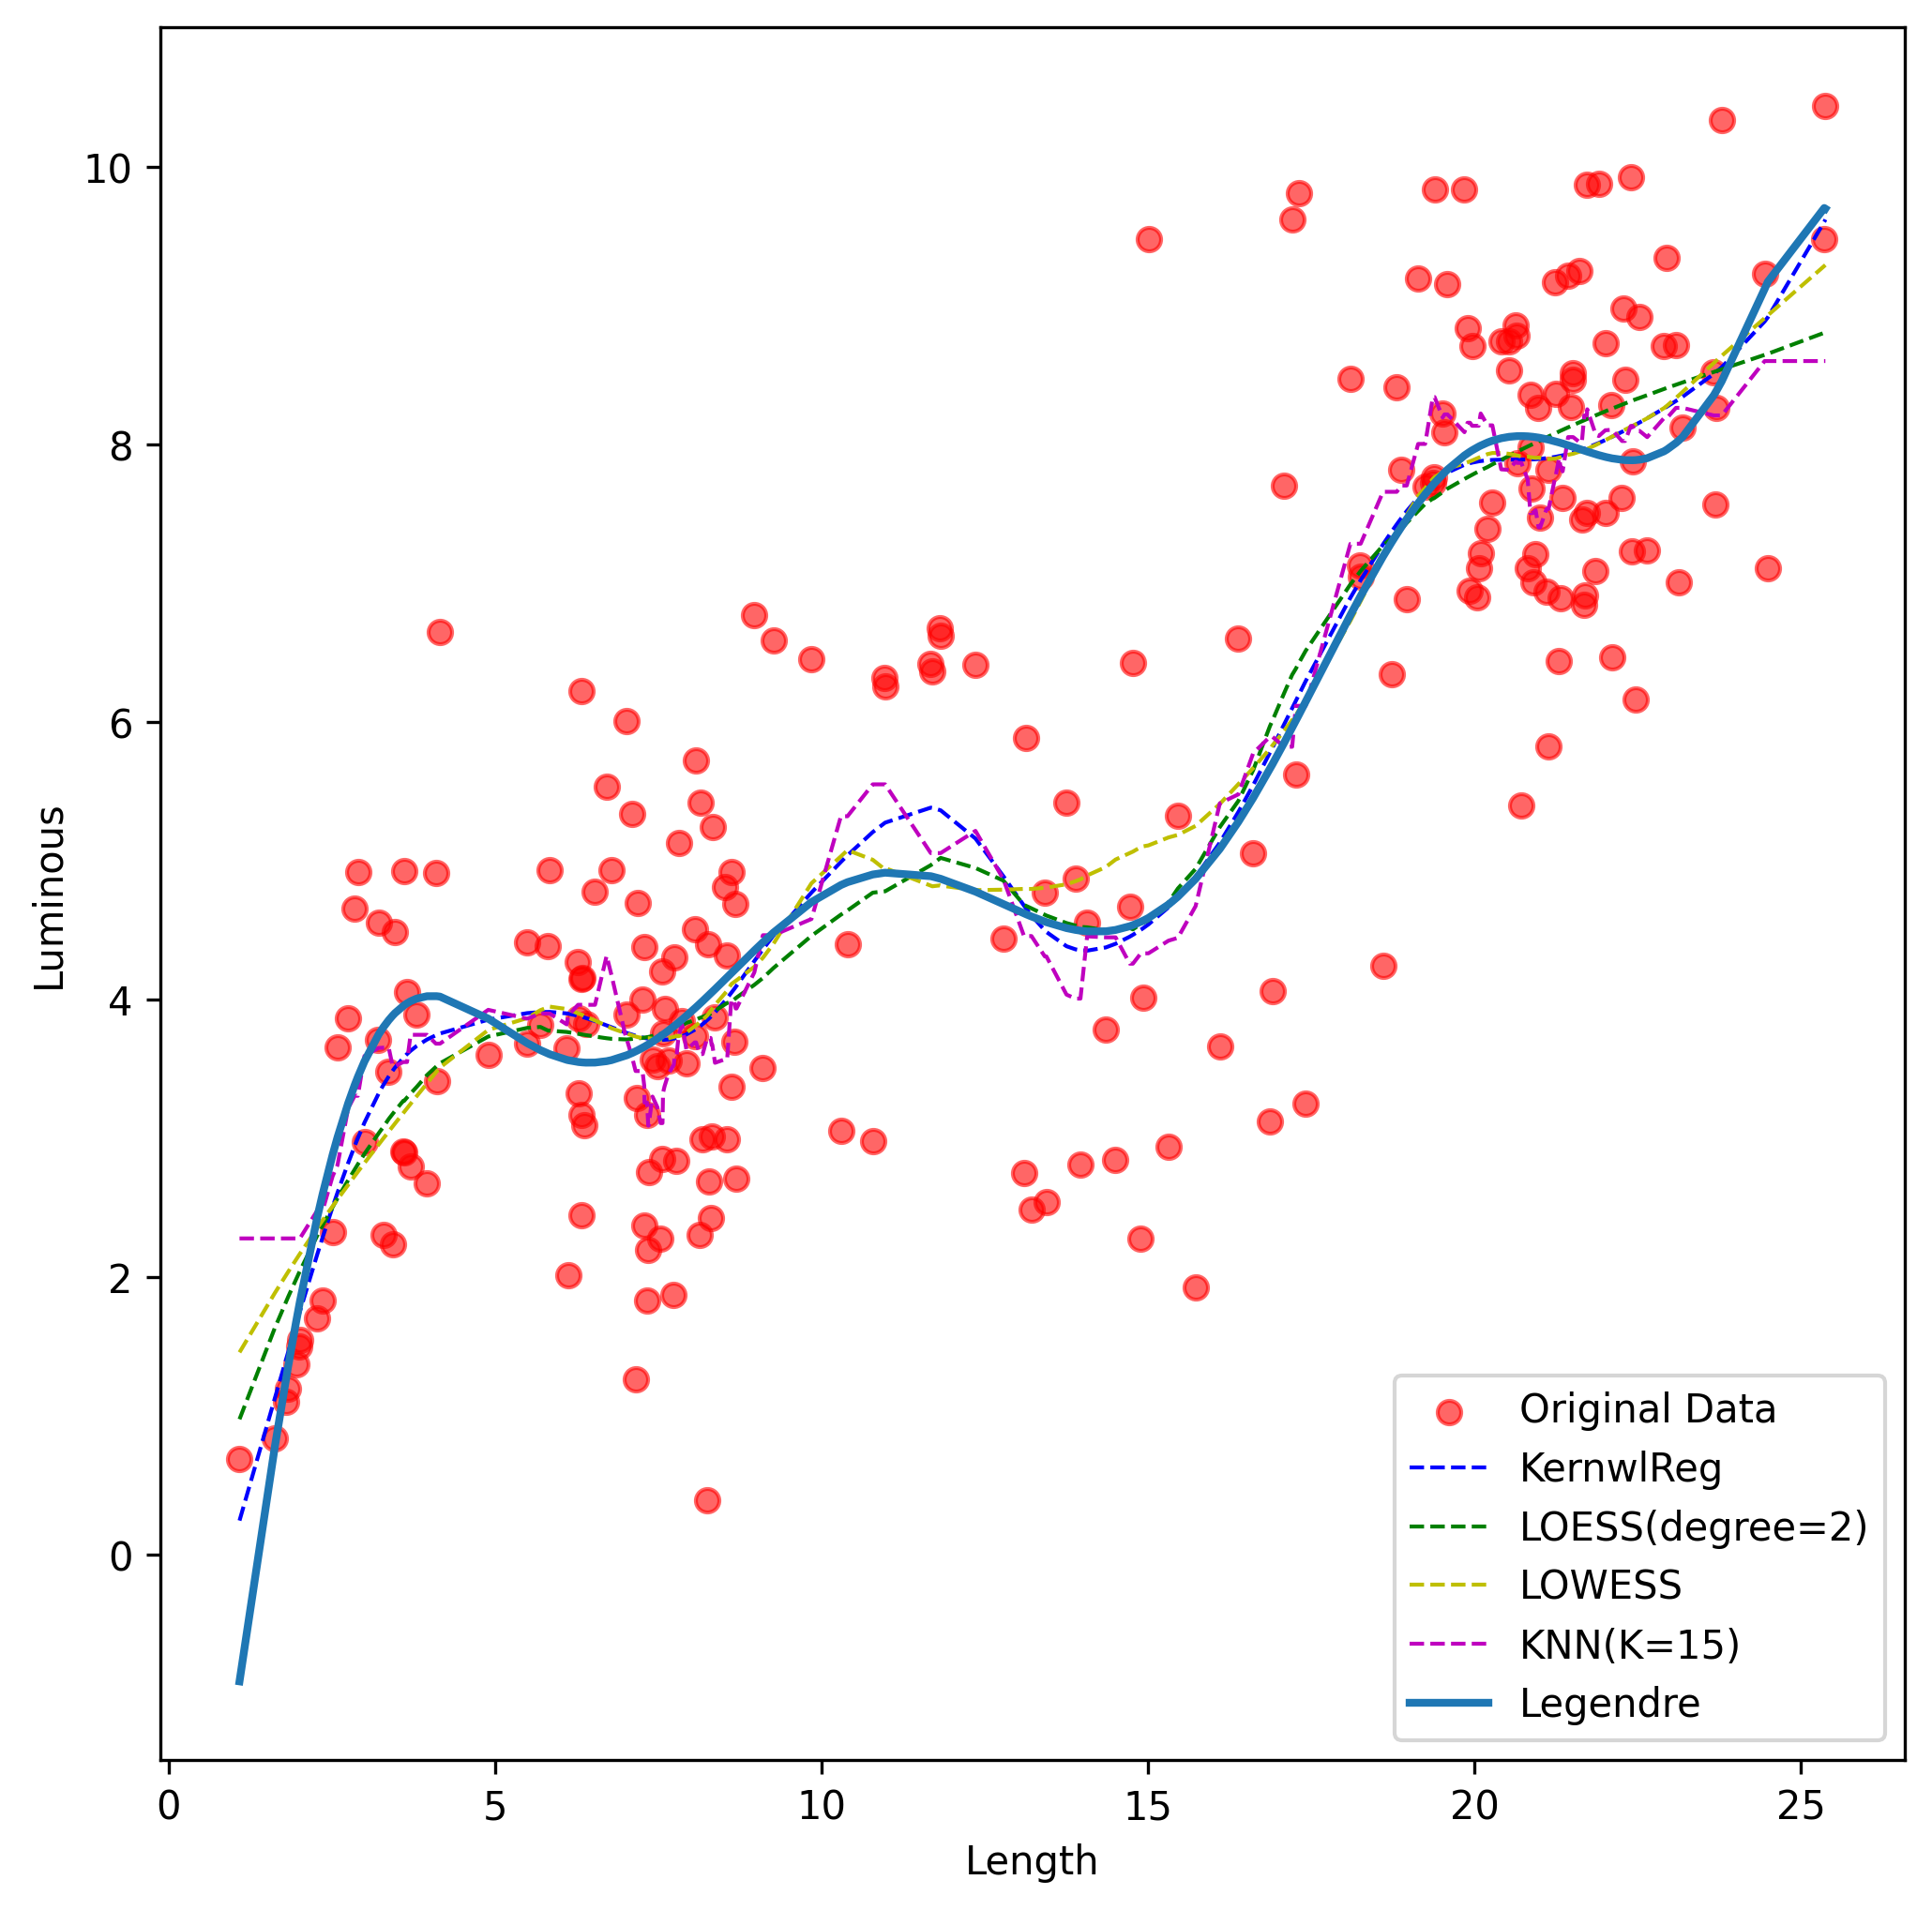

In [10]:
plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')

# 核回归光滑
result = smn.KernelReg(fish.luminous, fish.length, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[fish.length, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], 'b--', linewidth=1, label='KernwlReg')

# 局部多项式回归
xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g--', linewidth=1, label='LOESS(degree=2)')

# LOWESS稳健回归
lowess_fish=smn.lowess(fish.luminous, fish.length, frac=0.3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1], 'y--', linewidth=1, label='LOWESS')

# K为15的K近邻回归
knr = KNeighborsRegressor(n_neighbors=15)
knr.fit(np.array(fish.length).reshape(-1, 1), fish.luminous)
pre = knr.predict(np.array(fish.length).reshape(-1, 1))
knr_data = pd.DataFrame(np.c_[fish.length, pre]).sort_values(by=0)
plt.plot(knr_data[0], knr_data[1], 'm--', linewidth=1, label='KNN(K=15)')

# 正交序列回归：Legendre多项式
x = fish.length
y = fish.luminous
data = {'x':x, 'y':y}
def legendre_poly(x, order):
    return legendre.legvander(x, order - 1)[:, 1:]
formula = 'y~1+legendre_poly(x, 10)'
orthpoly_model = smf.ols(formula=formula, data=data)
result = orthpoly_model.fit()
y_hat=result.predict()
data=pd.DataFrame(np.c_[x,y_hat]).sort_values(by=0)
plt.plot(data[0], data[1], linewidth=2, label='Legendre')

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower right')
plt.show()

### 7 罚最小二乘法：岭回归

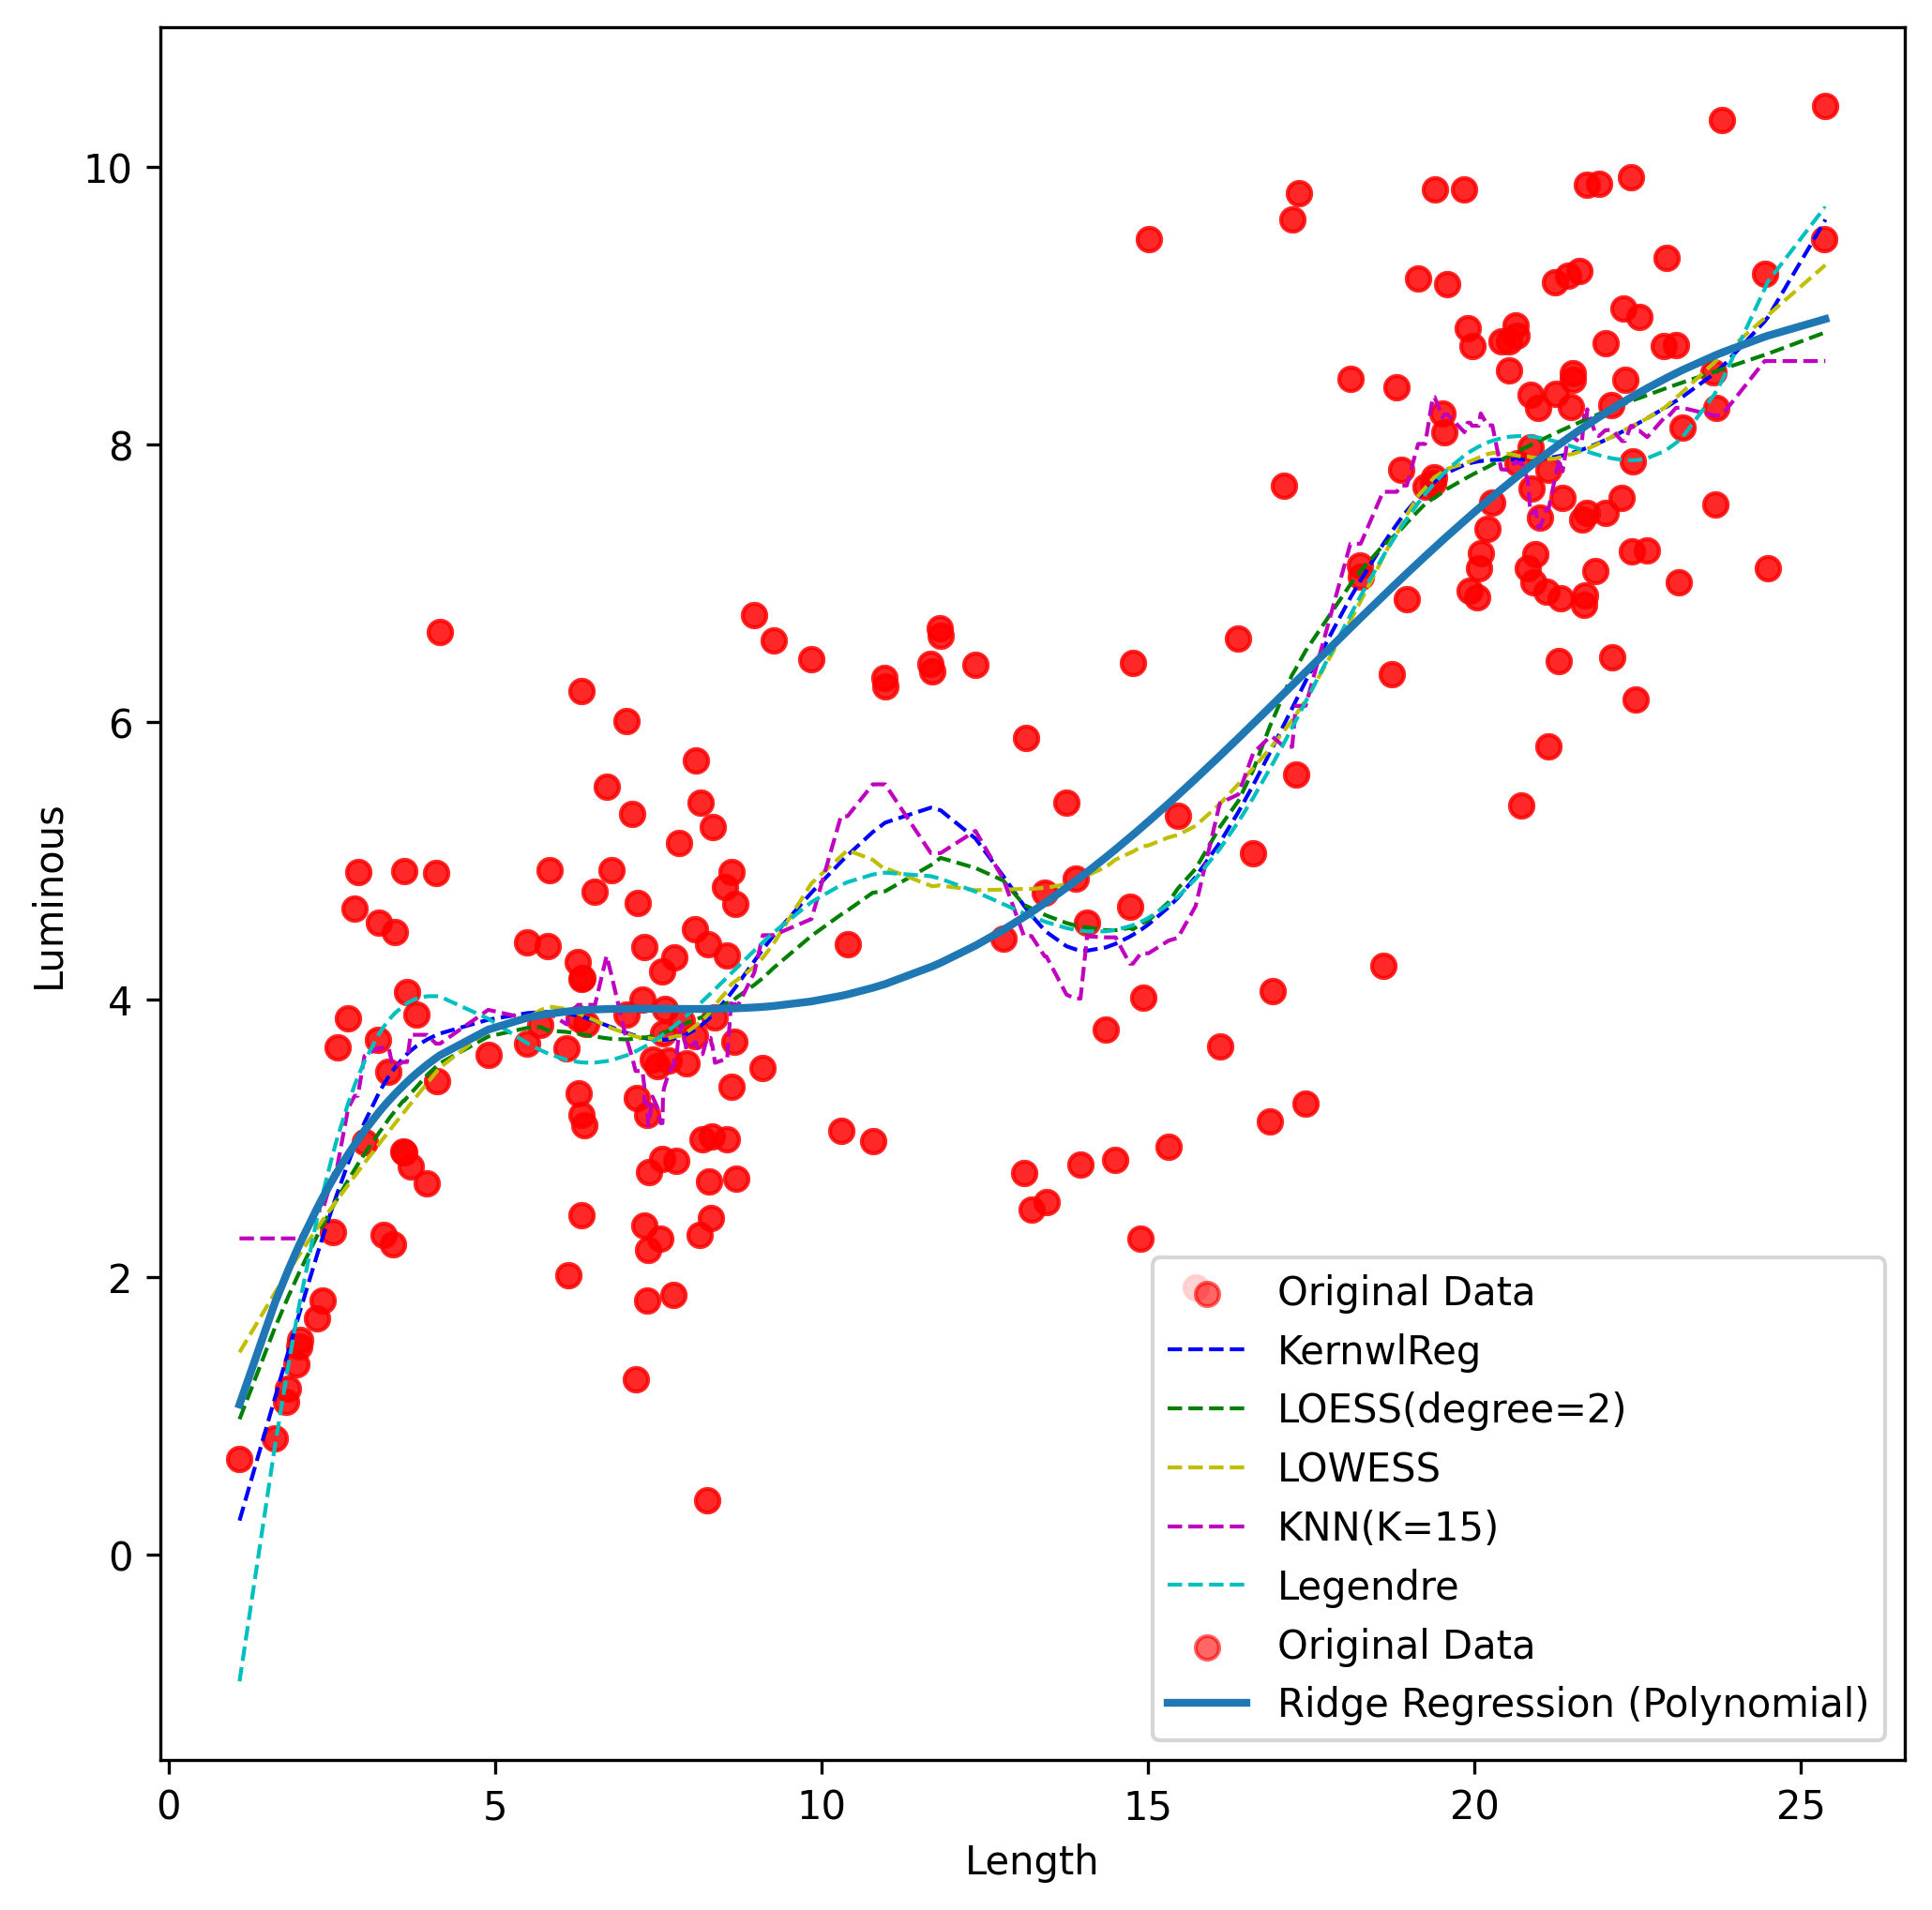

In [11]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')

# 核回归光滑
result = smn.KernelReg(fish.luminous, fish.length, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[fish.length, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], 'b--', linewidth=1, label='KernwlReg')

# 局部多项式回归
xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g--', linewidth=1, label='LOESS(degree=2)')

# LOWESS稳健回归
lowess_fish=smn.lowess(fish.luminous, fish.length, frac=0.3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1], 'y--', linewidth=1, label='LOWESS')

# K为15的K近邻回归
knr = KNeighborsRegressor(n_neighbors=15)
knr.fit(np.array(fish.length).reshape(-1, 1), fish.luminous)
pre = knr.predict(np.array(fish.length).reshape(-1, 1))
knr_data = pd.DataFrame(np.c_[fish.length, pre]).sort_values(by=0)
plt.plot(knr_data[0], knr_data[1], 'm--', linewidth=1, label='KNN(K=15)')

# 正交序列回归：Legendre多项式
x = fish.length
y = fish.luminous
data = {'x':x, 'y':y}
formula = 'y~1+legendre_poly(x, 10)'
orthpoly_model = smf.ols(formula=formula, data=data)
result = orthpoly_model.fit()
y_hat=result.predict()
data=pd.DataFrame(np.c_[x,y_hat]).sort_values(by=0)
plt.plot(data[0], data[1], 'c--', linewidth=1, label='Legendre')

# 多项式特征变换、罚最小二乘（Ridge回归）
poly = PolynomialFeatures(degree=5)
X = np.array(fish.length).reshape(-1, 1)
X_poly = poly.fit_transform(X)
y = fish.luminous
ridge = Ridge(alpha=1)
ridge.fit(X_poly, y)
y_pred = ridge.predict(X_poly)

ridge_data = pd.DataFrame(np.c_[fish.length, y_pred]).sort_values(by=0)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')
plt.plot(ridge_data[0], ridge_data[1], linewidth=2, label='Ridge Regression (Polynomial)')

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower right')
plt.show()

### 8 样条回归：BSpline

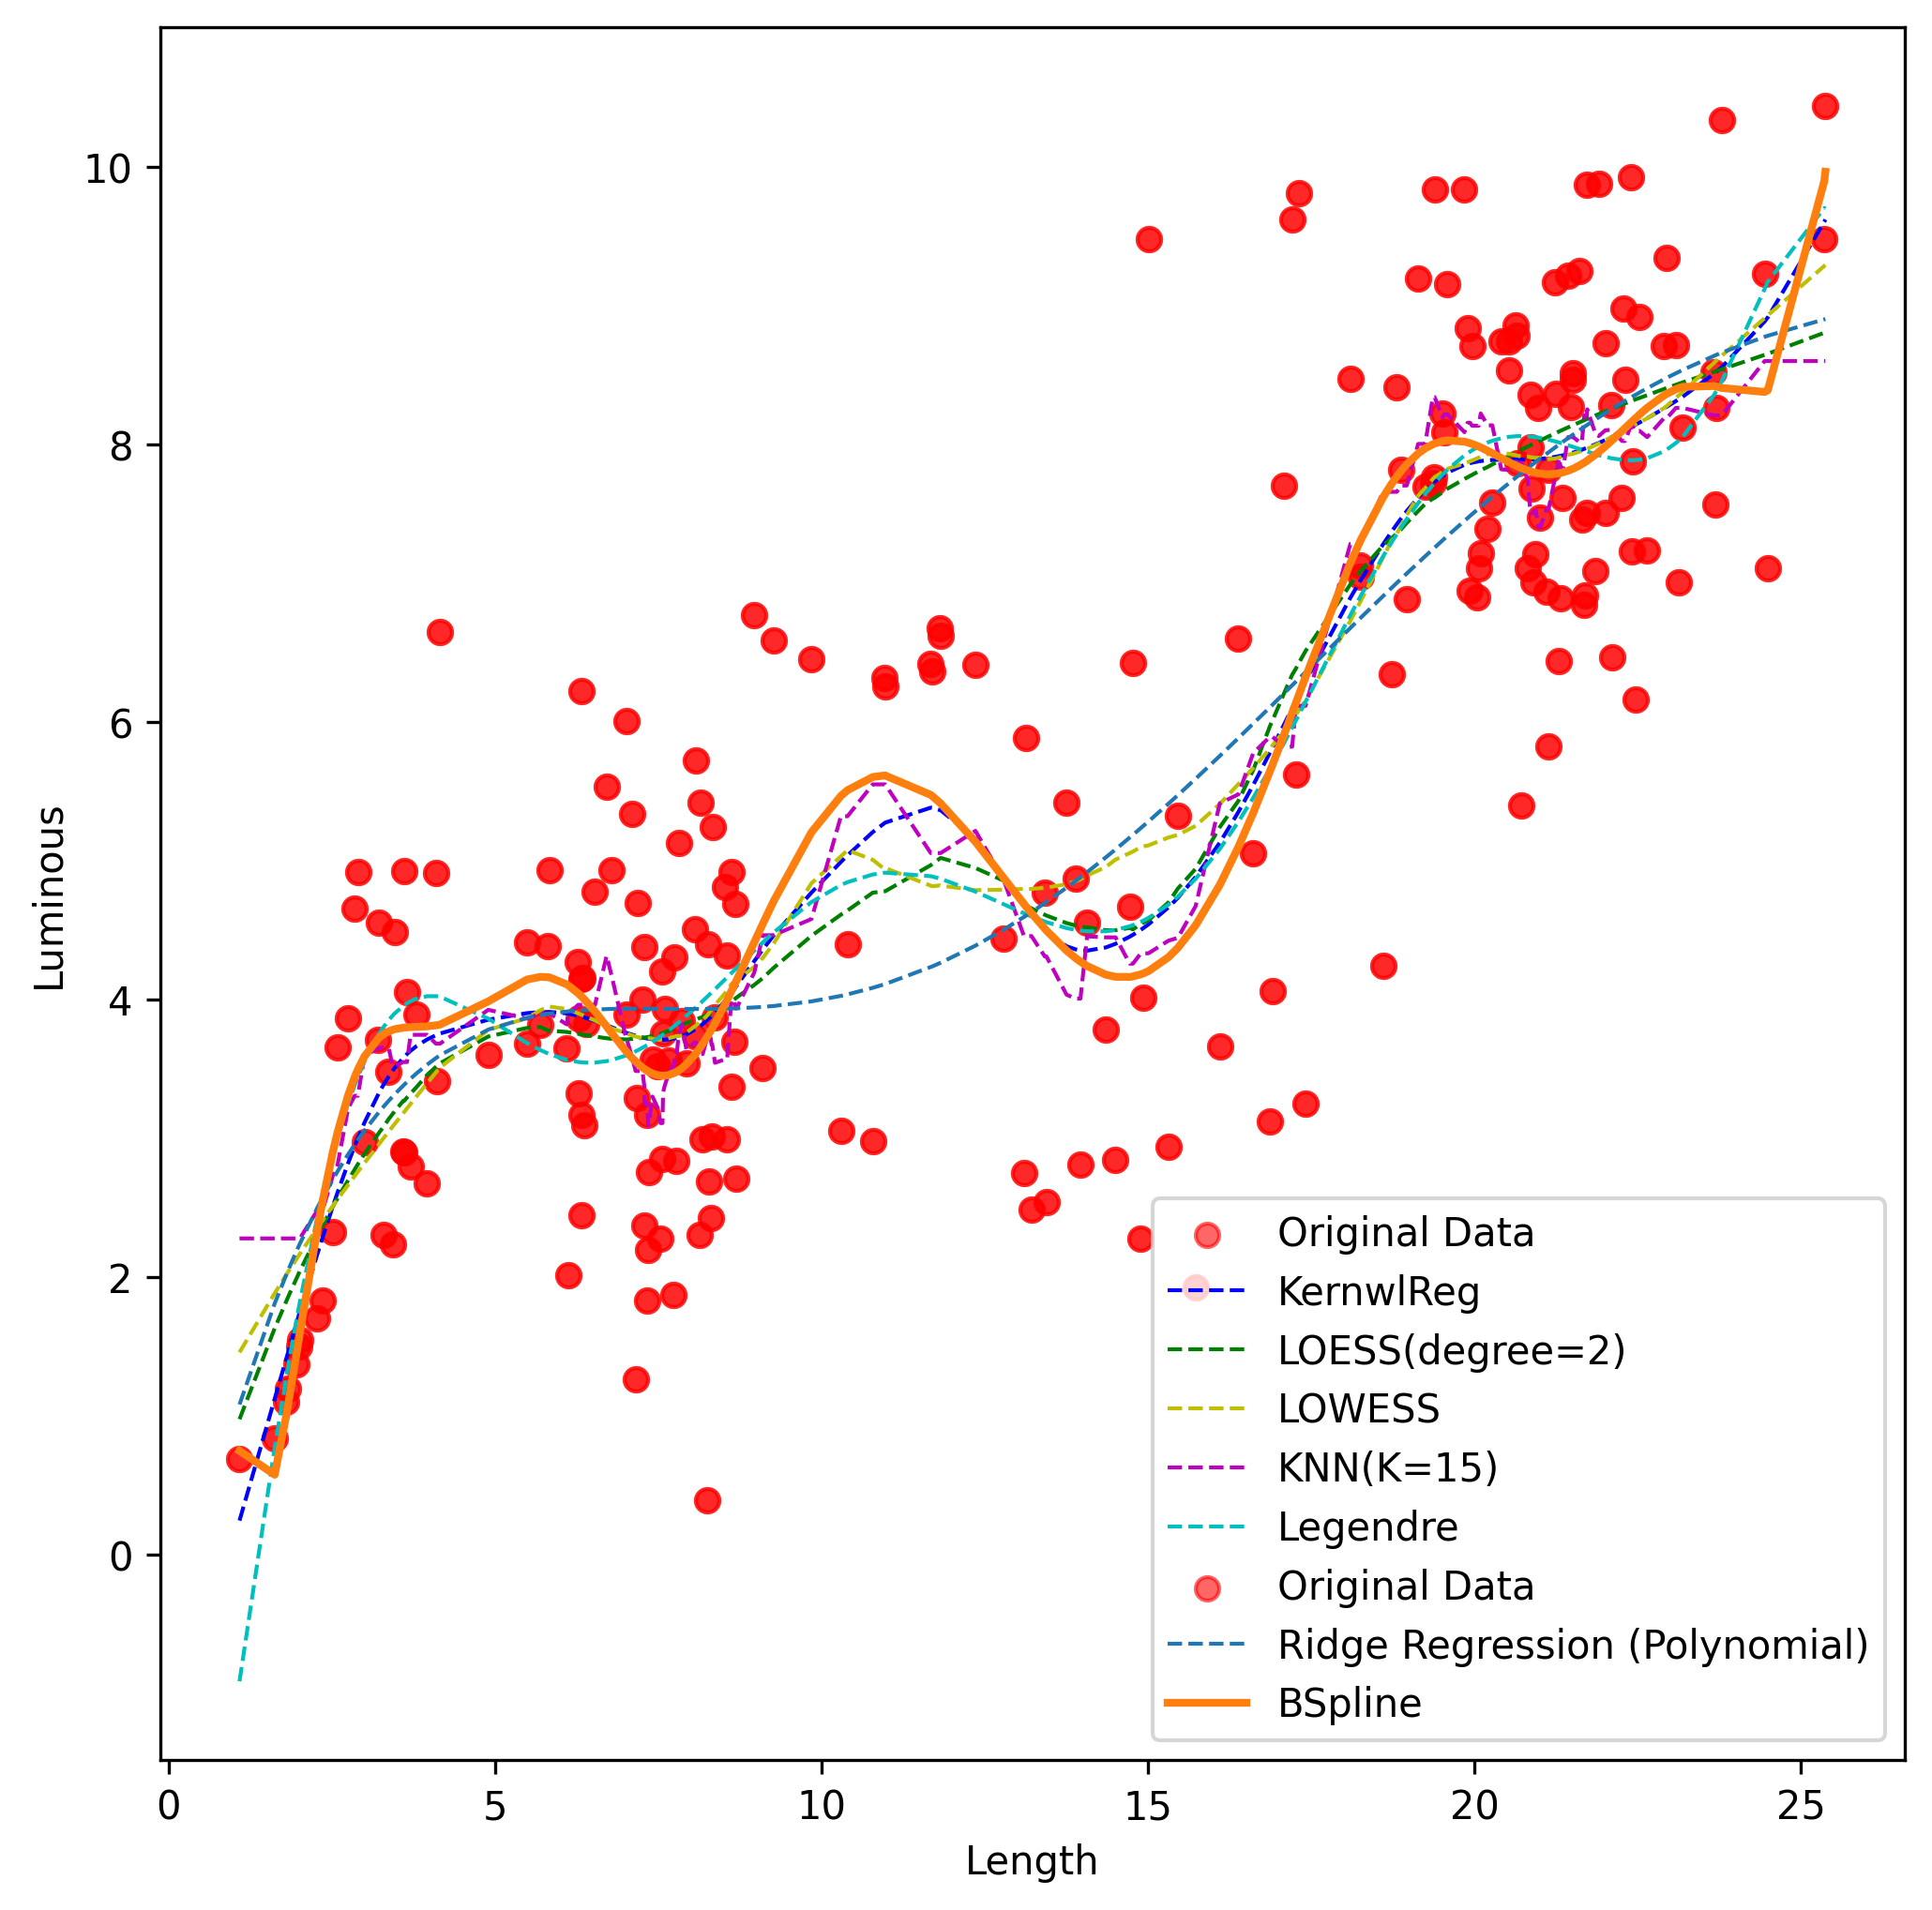

In [13]:
import statsmodels.api as sm

plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')

# 核回归光滑
result = smn.KernelReg(fish.luminous, fish.length, bw='cv_ls', var_type='c').fit()
data = pd.DataFrame(np.c_[fish.length, result[0]]).sort_values(by=0)
plt.plot(data[0], data[1], 'b--', linewidth=1, label='KernwlReg')

# 局部多项式回归
xout, yout, weigts = loess_1d(np.array(fish.length), np.array(fish.luminous), frac=0.5, degree=2)
out = pd.DataFrame(np.c_[xout,yout]).sort_values(by=0)
plt.plot(out[0], out[1], 'g--', linewidth=1, label='LOESS(degree=2)')

# LOWESS稳健回归
lowess_fish=smn.lowess(fish.luminous, fish.length, frac=0.3)
plt.plot(lowess_fish[:,0],lowess_fish[:,1], 'y--', linewidth=1, label='LOWESS')

# K为15的K近邻回归
knr = KNeighborsRegressor(n_neighbors=15)
knr.fit(np.array(fish.length).reshape(-1, 1), fish.luminous)
pre = knr.predict(np.array(fish.length).reshape(-1, 1))
knr_data = pd.DataFrame(np.c_[fish.length, pre]).sort_values(by=0)
plt.plot(knr_data[0], knr_data[1], 'm--', linewidth=1, label='KNN(K=15)')

# 正交序列回归：Legendre多项式
x = fish.length
y = fish.luminous
data = {'x':x, 'y':y}
formula = 'y~1+legendre_poly(x, 10)'
orthpoly_model = smf.ols(formula=formula, data=data)
result = orthpoly_model.fit()
y_hat=result.predict()
data=pd.DataFrame(np.c_[x,y_hat]).sort_values(by=0)
plt.plot(data[0], data[1], 'c--', linewidth=1, label='Legendre')

# 多项式特征变换、罚最小二乘（Ridge回归）
poly = PolynomialFeatures(degree=5)
X = np.array(fish.length).reshape(-1, 1)
X_poly = poly.fit_transform(X)
y = fish.luminous
ridge = Ridge(alpha=1)
ridge.fit(X_poly, y)
y_pred = ridge.predict(X_poly)

ridge_data = pd.DataFrame(np.c_[fish.length, y_pred]).sort_values(by=0)
plt.scatter(fish.length, fish.luminous, alpha=0.6, label='Original Data', color='r')
plt.plot(ridge_data[0], ridge_data[1], '--',linewidth=1, label='Ridge Regression (Polynomial)')

# BSpline
xspl = sm.gam.BSplines(fish.length, df=15, degree=5)
formula = 'y~x'
result = smf.ols(formula,{'y':fish.luminous,'x':xspl.basis}).fit()
pred = result.get_prediction()
spres = pd.DataFrame(np.c_[fish.length, pred.predicted_mean]).sort_values(by=0)
plt.plot(spres[0], spres[1], label='BSpline', linewidth=2)

plt.xlabel('Length')
plt.ylabel('Luminous')
plt.legend(loc='lower right')
plt.show()